## Problem Statement

The fashion e-commerce industry faces challenges in automatically categorizing and tagging product images with relevant attributes like color, article type, season, and gender. This manual process is time-consuming and can be prone to inconsistencies. The goal is to develop an automated system that can accurately predict these attributes from product images.

## Aim of the Project
1. **Exploratory Data Analysis**

2. The aim of this project is to build a deep learning model that can take a fashion product image as input and predict the following attributes:
  1. **Product Color:** Identify the primary color of the product in the image.
  2. **Product Type:** Classify the type of article (e.g., T-shirt, Jeans, Watch).
  3. **Preferable Season:** Determine the season for which the product is most suitable.
  4. **Product Gender:** Categorize the product based on the intended gender (Men, Women, Unisex, Boys, Girls).

This will enable efficient product tagging, improved search functionality, and better product recommendations on e-commerce platforms.

### Import the dataset from the kaggle

In [1]:
import kagglehub


path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/fashion-product-images-dataset


## Import the  libraries

In [4]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2 as cv
import warnings
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Dense, Flatten, Input
from tensorflow.keras.models import Model
warnings.filterwarnings('ignore')



In [2]:
import os

downloaded_folder_path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset"

# List all files and directories in the downloaded folder
for item in os.listdir(downloaded_folder_path):
    print(item)

images.csv
images
styles.csv
styles
fashion-dataset


In [3]:
# List out no.of images
len(os.listdir(os.path.join(downloaded_folder_path,'images')))

44441

In [5]:
# set the paths
BASE_PATH = "/kaggle/input/fashion-product-images-dataset/fashion-dataset"
IMAGES_PATH = os.path.join(BASE_PATH, 'images.csv')
STYLES_CSV_PATH = os.path.join(BASE_PATH, 'styles.csv')

print(f"Loading data from: {STYLES_CSV_PATH}")

Loading data from: /kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv


In [6]:
# read the styles file
styles_df = pd.read_csv(STYLES_CSV_PATH, on_bad_lines='skip')

In [7]:
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [8]:
# read the images file
images_df=pd.read_csv(IMAGES_PATH)

#### Merge dataframes

Merge the "styles_df" and "images_df" dataFrames based on the image filename and style ID.


In [9]:
styles_df['filename'] = styles_df['id'].astype(str) + '.jpg'

df = pd.merge(styles_df, images_df, on='filename', how='inner')

In [10]:
styles_df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg


In [11]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,http://assets.myntassets.com/v1/images/style/p...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,http://assets.myntassets.com/v1/images/style/p...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg,http://assets.myntassets.com/v1/images/style/p...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,http://assets.myntassets.com/v1/images/style/p...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,http://assets.myntassets.com/v1/images/style/p...


#### Construct image paths

Create a new column in the merged DataFrame with the full path to each image file.


In [12]:
df['image_path'] = BASE_PATH + '/images/' + df['filename']

#### Display sample images and details

Select a few random rows from the merged DataFrame and display the corresponding images and their details.


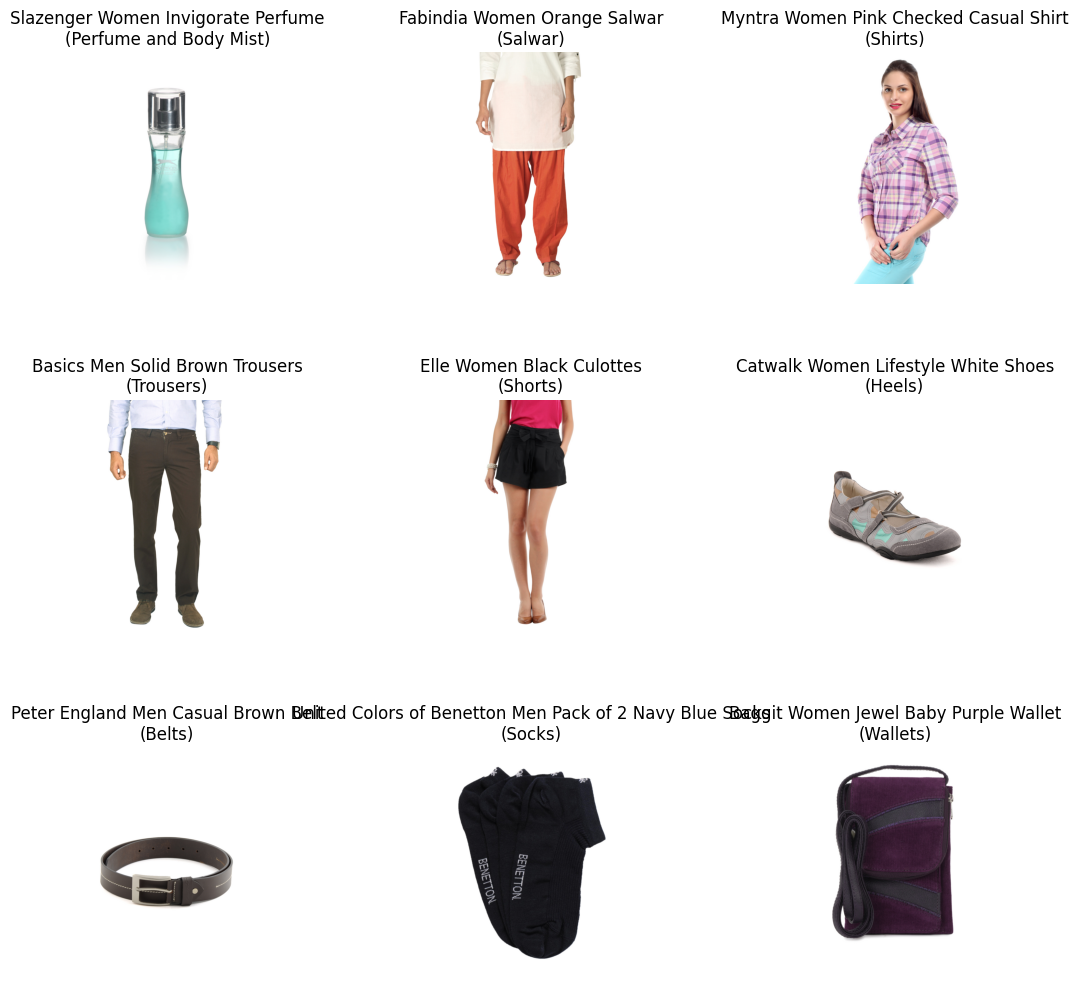

In [13]:
sample_df = df.sample(9)

fig, axes = plt.subplots(3, 3, figsize=(10, 10))
axes = axes.flatten()

for i, (index, row) in enumerate(sample_df.iterrows()):
    img_path = row['image_path']
    try:
        img = cv.imread(img_path)
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
        axes[i].imshow(img)
        axes[i].set_title(f"{row['productDisplayName']}\n({row['articleType']})")
        axes[i].axis('off')
    except Exception as e:
        print(f"Could not read image {img_path}: {e}")
        axes[i].set_title(f"Error loading image\n{row['filename']}")
        axes[i].axis('off')

plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.5)
plt.show()

In [14]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,/kaggle/input/fashion-product-images-dataset/f...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,/kaggle/input/fashion-product-images-dataset/f...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,59263.jpg,http://assets.myntassets.com/v1/images/style/p...,/kaggle/input/fashion-product-images-dataset/f...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,http://assets.myntassets.com/v1/images/style/p...,/kaggle/input/fashion-product-images-dataset/f...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,53759.jpg,http://assets.myntassets.com/v1/images/style/p...,/kaggle/input/fashion-product-images-dataset/f...


In [15]:
print(f"No.of Images :{df['id'].nunique()}")

No.of Images :44424


In [16]:
# list out the values in each feature
features = ['gender', 'masterCategory', 'subCategory', 'articleType', 'baseColour', 'season', 'year', 'usage']

for feature in features:
    print(f"Feature: {feature}")
    print(f"Number of unique values: {df[feature].nunique()}")
    print(f"Unique values: {df[feature].unique()}")
    print("--" * 30)

Feature: gender
Number of unique values: 5
Unique values: ['Men' 'Women' 'Boys' 'Girls' 'Unisex']
------------------------------------------------------------
Feature: masterCategory
Number of unique values: 7
Unique values: ['Apparel' 'Accessories' 'Footwear' 'Personal Care' 'Free Items'
 'Sporting Goods' 'Home']
------------------------------------------------------------
Feature: subCategory
Number of unique values: 45
Unique values: ['Topwear' 'Bottomwear' 'Watches' 'Socks' 'Shoes' 'Belts' 'Flip Flops'
 'Bags' 'Innerwear' 'Sandal' 'Shoe Accessories' 'Fragrance' 'Jewellery'
 'Lips' 'Saree' 'Eyewear' 'Nails' 'Scarves' 'Dress'
 'Loungewear and Nightwear' 'Wallets' 'Apparel Set' 'Headwear' 'Mufflers'
 'Skin Care' 'Makeup' 'Free Gifts' 'Ties' 'Accessories' 'Skin'
 'Beauty Accessories' 'Water Bottle' 'Eyes' 'Bath and Body' 'Gloves'
 'Sports Accessories' 'Cufflinks' 'Sports Equipment' 'Stoles' 'Hair'
 'Perfumes' 'Home Furnishing' 'Umbrellas' 'Wristbands' 'Vouchers']
----------------------

### Analysis about the each feature values.
- **gender**: There are 5 unique values: 'Men', 'Women', 'Boys', 'Girls', and 'Unisex'.
- **masterCategory**: There are 7 unique values: 'Apparel', 'Accessories', 'Footwear', 'Personal Care', 'Free Items', 'Sporting Goods', and 'Home'. 'Apparel'.
- **subCategory**: There are 45 unique values, suggesting a diverse range of product types within the master categories. This level of detail could be useful for more granular analysis or product categorization.
- **articleType**: With 143 unique values, this feature provides the most specific description of the products. This granularity could be useful for building highly specific recommendation systems or for detailed product analysis.
- **baseColour**: There are 46 unique values, indicating a wide variety of colors in the dataset. There is also a nan value, which might require handling depending on the analysis.
- **season**: There are 4 unique values: 'Fall', 'Summer', 'Winter', and 'Spring', along with a nan value. This feature allows for analyzing fashion trends across different seasons.
- **year**: There are 13 unique values representing years from 2007 to 2019, including a nan value. This feature can be used to analyze how fashion trends or product availability have changed over time.
- **usage**: There are 8 unique values: 'Casual', 'Ethnic', 'Formal', 'Sports', 'Smart Casual', 'Travel', 'Party', and 'Home', with a nan value. This feature provides context on the intended use or occasion for the product.
Overall, these features provide a rich set of categorical information that can be used for various analyses, such as:


In [ ]:
df.describe()

,id,year
count,44424.000000,44423.000000
mean,29696.334301,2012.806497
std,17049.490518,2.126480
min,1163.000000,2007.000000
25%,14768.750000,2011.000000
50%,28618.500000,2012.000000
75%,44683.250000,2015.000000
max,60000.000000,2019.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44424 non-null  int64  
 1   gender              44424 non-null  object 
 2   masterCategory      44424 non-null  object 
 3   subCategory         44424 non-null  object 
 4   articleType         44424 non-null  object 
 5   baseColour          44409 non-null  object 
 6   season              44403 non-null  object 
 7   year                44423 non-null  float64
 8   usage               44107 non-null  object 
 9   productDisplayName  44417 non-null  object 
 10  filename            44424 non-null  object 
 11  link                44424 non-null  object 
 12  image_path          44424 non-null  object 
dtypes: float64(1), int64(1), object(11)
memory usage: 4.4+ MB


In [ ]:
df.isnull().sum()

,0
id,0
gender,0
masterCategory,0
subCategory,0
articleType,0
baseColour,15
season,21
year,1
usage,317
productDisplayName,7


- The dataset contains null values in baseColor, season, year and Usage features

In [ ]:
df.duplicated().sum()

np.int64(0)

- No duplicate values

gender
Men       22147
Women     18631
Unisex     2161
Boys        830
Girls       655
Name: count, dtype: int64


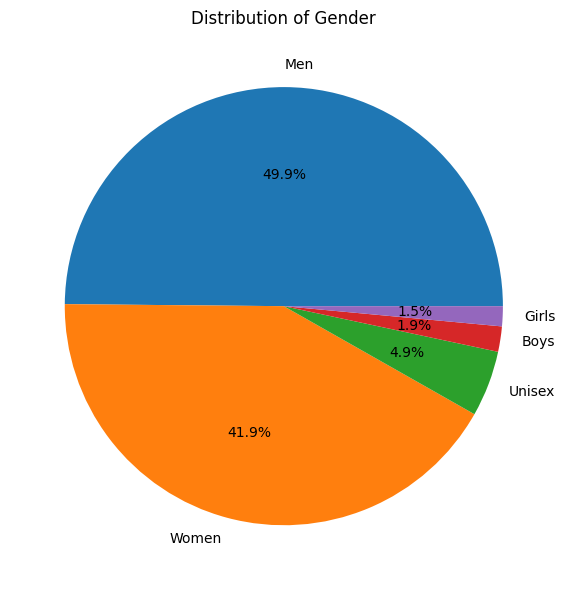

In [ ]:
# Distribution of gender feature
gender_distribution = df['gender'].value_counts()
print(gender_distribution)
plt.figure(figsize=(8, 6))
gender_distribution.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Gender')
plt.ylabel('')
plt.tight_layout()
plt.show()

masterCategory
Apparel           21397
Accessories       11274
Footwear           9219
Personal Care      2403
Free Items          105
Sporting Goods       25
Home                  1
Name: count, dtype: int64


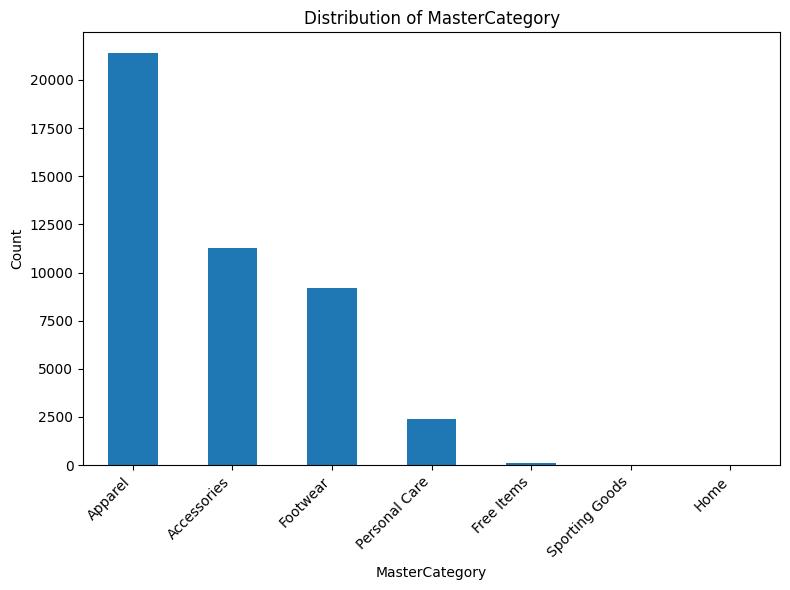

In [ ]:
# Distribution of Mastercategory feature
masterCategory_dist = df['masterCategory'].value_counts()
print(masterCategory_dist)
plt.figure(figsize=(8, 6))
masterCategory_dist.plot(kind='bar')
plt.title('Distribution of MasterCategory')
plt.xlabel('MasterCategory')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

subCategory
Topwear                     15402
Shoes                        7343
Bags                         3055
Bottomwear                   2694
Watches                      2542
Innerwear                    1808
Jewellery                    1079
Eyewear                      1073
Fragrance                    1011
Sandal                        963
Wallets                       933
Flip Flops                    913
Belts                         811
Socks                         698
Lips                          527
Dress                         478
Loungewear and Nightwear      470
Saree                         427
Nails                         329
Makeup                        307
Name: count, dtype: int64


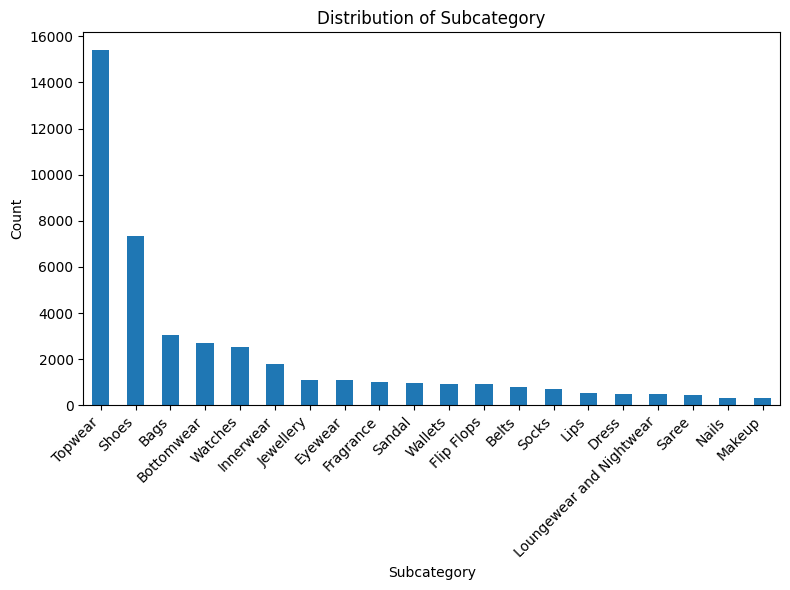

In [ ]:
# Distribution of Subcategory
subCategory_dist = df['subCategory'].value_counts()[:20]
print(subCategory_dist)
plt.figure(figsize=(8, 6))
subCategory_dist.plot(kind='bar')
plt.title('Distribution of Subcategory')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

articleType
Tshirts                  7067
Shirts                   3217
Casual Shoes             2845
Watches                  2542
Sports Shoes             2036
Kurtas                   1844
Tops                     1762
Handbags                 1759
Heels                    1323
Sunglasses               1073
Wallets                   936
Flip Flops                914
Sandals                   897
Briefs                    849
Belts                     813
Backpacks                 724
Socks                     686
Formal Shoes              637
Perfume and Body Mist     613
Jeans                     609
Name: count, dtype: int64


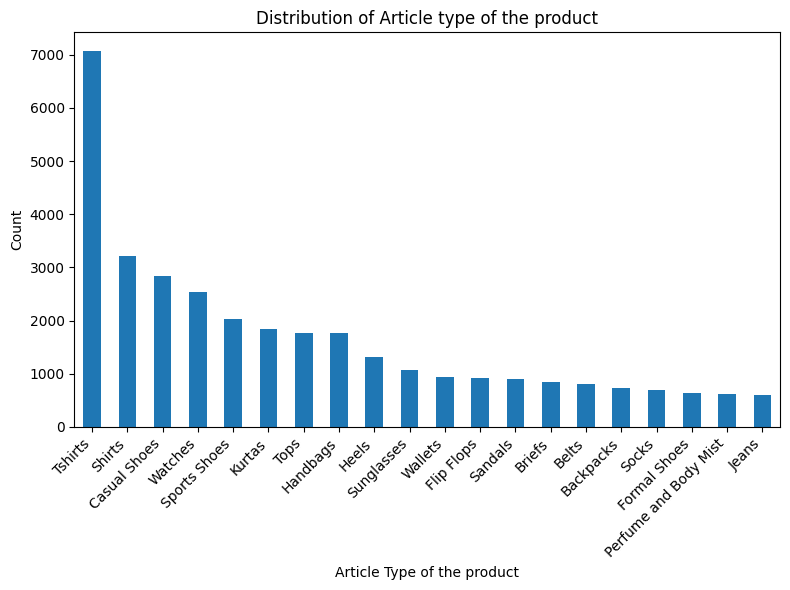

In [ ]:
# Distribution of Articletype
article_dist = df['articleType'].value_counts()[:20]
print(article_dist)
plt.figure(figsize=(8, 6))
article_dist.plot(kind='bar')
plt.title('Distribution of Article type of the product')
plt.xlabel('Article Type of the product')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

baseColour
Black        9728
White        5538
Blue         4918
Brown        3494
Grey         2741
Red          2455
Green        2115
Pink         1860
Navy Blue    1789
Purple       1640
Silver       1090
Yellow        778
Beige         749
Gold          628
Maroon        581
Orange        530
Olive         410
Multi         394
Cream         390
Steel         315
Name: count, dtype: int64


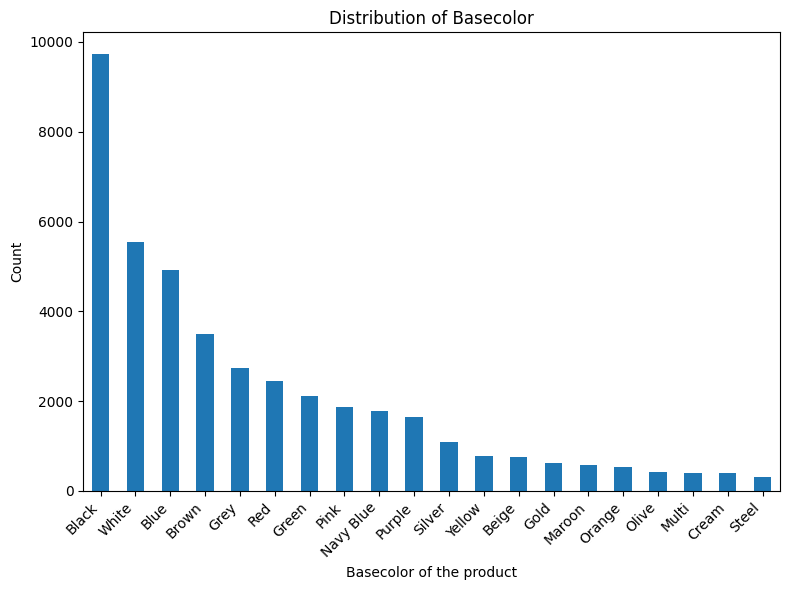

In [ ]:
# Distribution of basecolor
basecolor_dist = df['baseColour'].value_counts()[:20]
print(basecolor_dist)
plt.figure(figsize=(8, 6))
basecolor_dist.plot(kind='bar')
plt.title('Distribution of Basecolor')
plt.xlabel('Basecolor of the product')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

season
Summer    21472
Fall      11431
Winter     8517
Spring     2983
Name: count, dtype: int64


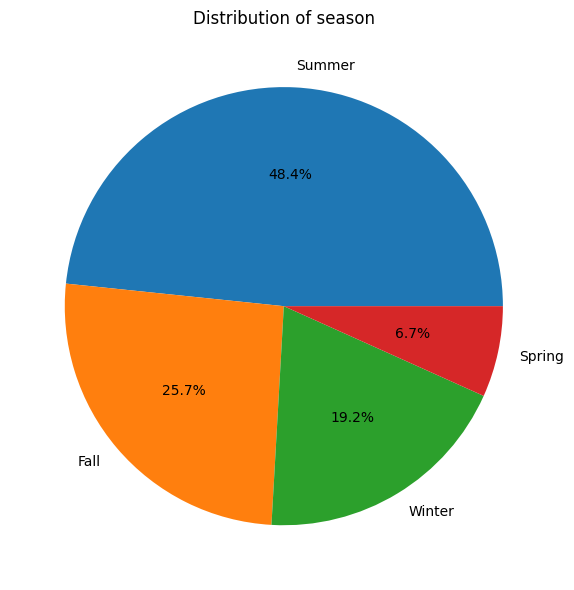

In [ ]:
# Distribution of season feature by pie chart
season_dist = df['season'].value_counts()
print(season_dist)
plt.figure(figsize=(8, 6))
season_dist.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of season')
plt.ylabel('')
plt.tight_layout()
plt.show()

year
2012    16287
2011    13672
2016     6006
2017     2911
2015     2780
2013     1212
2010      846
2018      405
2014      236
2019       33
2009       20
2008        7
2007        2
Name: count, dtype: int64


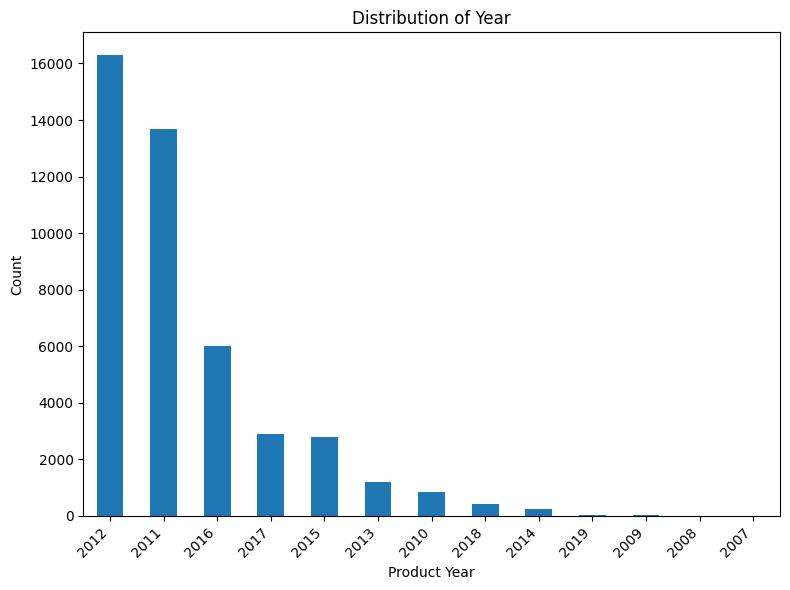

In [ ]:

year_dist = df['year'].value_counts()
print(year_dist)
plt.figure(figsize=(8, 6))
year_dist.plot(kind='bar')
plt.title('Distribution of Year')
plt.xlabel('Product Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

usage
Casual          34406
Sports           4025
Ethnic           3208
Formal           2345
Smart Casual       67
Party              29
Travel             26
Home                1
Name: count, dtype: int64


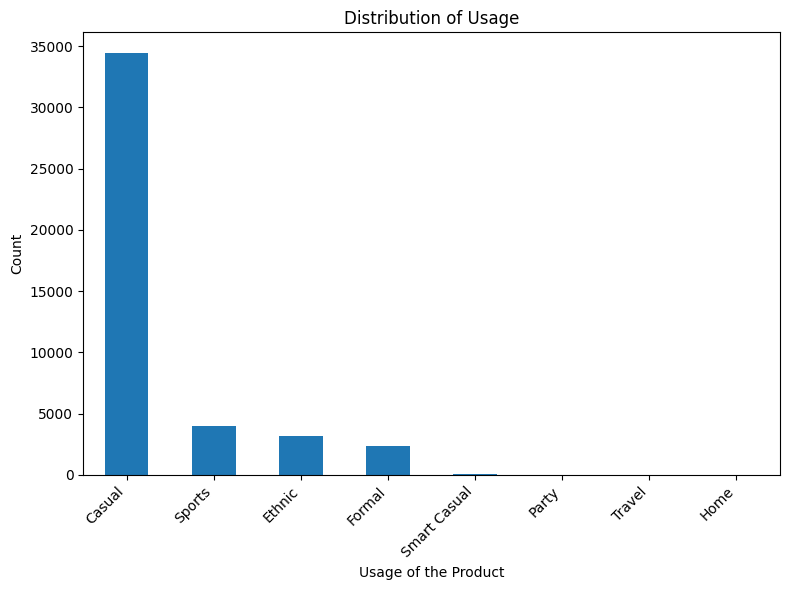

In [ ]:

usage_dist = df['usage'].value_counts()
print(usage_dist)
plt.figure(figsize=(8, 6))
usage_dist.plot(kind='bar')
plt.title('Distribution of Usage')
plt.xlabel('Usage of the Product')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Plots:**

*   **Gender Distribution:** The plot shows that the dataset is predominantly skewed towards 'Men' and 'Women' products, with a smaller number of 'Unisex', 'Boys', and 'Girls' items.
*   **Master Category Distribution:** 'Apparel' is the most frequent master category, followed by 'Accessories' and 'Footwear'. Other categories like 'Personal Care', 'Free Items', 'Sporting Goods', and 'Home' have significantly fewer items.
*   **Subcategory Distribution:** 'Topwear' is the most common subcategory, followed by 'Shoes' and 'Bags'. There's a long tail of less frequent subcategories.
*   **Article Type Distribution:** 'Tshirts' are the most common article type, followed by 'Shirts' and 'Casual Shoes'. Similar to subcategories, there's a wide variety of less frequent article types.
*   **Base Colour Distribution:** 'Black', 'White', and 'Blue' are the most prevalent base colors, with a gradual decrease in the count of other colors.
*   **Season Distribution:** 'Summer' is the most represented season in the dataset, followed by 'Fall' and 'Winter'. 'Spring' has the fewest items.
*   **Year Distribution:** The years 2011 and 2012 have the highest number of products, with a decreasing trend in the following years. There's a sharp drop after 2017.
*   **Usage Distribution:** 'Casual' is overwhelmingly the most common usage for the products, with 'Sports', 'Ethnic', and 'Formal' having considerably fewer items. 'Smart Casual', 'Party', 'Travel', and 'Home' usages are very infrequent.

#### Analyze missing values

Re-examine the columns with missing values to understand their distribution and potential impact.


In [17]:
print("Missing values before handling:")
print(df.isnull().sum())

Missing values before handling:
id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 21
year                    1
usage                 317
productDisplayName      7
filename                0
link                    0
image_path              0
dtype: int64


In [18]:
# Display rows with missing values in the identified columns
missing_values_rows = df[df['baseColour'].isnull() |
                         df['season'].isnull() |
                         df['year'].isnull() |
                         df['usage'].isnull() |
                         df['productDisplayName'].isnull()]

print("Rows with missing values:")
display(missing_values_rows)

Rows with missing values:


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,image_path
87,56489,Women,Personal Care,Nails,Nail Polish,Bronze,Spring,2017.0,NaN,Streetwear Ash Nail Polish # 31,56489.jpg,http://assets.myntassets.com/v1/images/style/p...,/kaggle/input/fashion-product-images-dataset/f...
92,52029,Unisex,Apparel,Topwear,Rain Jacket,Coffee Brown,Summer,2012.0,NaN,Just Natural Unisex Charcoal Rain Jacket,52029.jpg,http://assets.myntassets.com/v1/images/style/p...,/kaggle/input/fashion-product-images-dataset/f...
282,5402,Women,Footwear,Shoes,Sports Shoes,Purple,NaN,2011.0,Sports,Kalenji Ekiden 200 Wn Purple 2011,5402.jpg,http://assets.myntassets.com/v1/images/style/p...,/kaggle/input/fashion-product-images-dataset/f...
292,55001,Women,Personal Care,Lips,Lipstick,Pink,Spring,2017.0,NaN,Lakme Absolute Lip Last Day Kiss Lip Colour,55001.jpg,http://assets.myntassets.com/assets/images/550...,/kaggle/input/fashion-product-images-dataset/f...
479,57563,Women,Personal Care,Lips,Lipstick,Brown,Spring,2017.0,NaN,Lotus Herbals Pure Colours Nutty Brown Lipstic...,57563.jpg,http://assets.myntassets.com/assets/images/575...,/kaggle/input/fashion-product-images-dataset/f...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43633,56605,Women,Personal Care,Makeup,Kajal and Eyeliner,Black,Spring,2017.0,NaN,Streetwear Black Eye Liner 01,56605.jpg,http://assets.myntassets.com/v1/images/style/p...,/kaggle/input/fashion-product-images-dataset/f...
44079,57715,Women,Personal Care,Lips,Lip Gloss,Red,Spring,2017.0,NaN,Lotus Herbals Seduction Sappy Watermelon Lip G...,57715.jpg,http://assets.myntassets.com/v1/images/style/p...,/kaggle/input/fashion-product-images-dataset/f...
44224,43120,Men,Personal Care,Fragrance,Perfume and Body Mist,NaN,Spring,2017.0,NaN,GUESS by Marciano Men Eau De Toilette 50 ml,43120.jpg,http://assets.myntassets.com/assets/images/431...,/kaggle/input/fashion-product-images-dataset/f...
44227,55045,Women,Personal Care,Lips,Lipstick,Purple,Spring,2017.0,NaN,Lakme Enrich Satins Lipstick 461,55045.jpg,http://assets.myntassets.com/v1/images/style/p...,/kaggle/input/fashion-product-images-dataset/f...


In [19]:
# Calculate the mode for each column
mode_basecolour = df['baseColour'].mode()[0]
mode_season = df['season'].mode()[0]
mode_year = df['year'].mode()[0]
mode_usage = df['usage'].mode()[0]

# Fill missing values with the calculated modes
df['baseColour'].fillna(mode_basecolour, inplace=True)
df['season'].fillna(mode_season, inplace=True)
df['year'].fillna(mode_year, inplace=True)
df['usage'].fillna(mode_usage, inplace=True)

# Convert 'year' column to integer type
df['year'] = df['year'].astype(int)

# Verify that missing values have been filled
print("Missing values after imputation:")
print(df.isnull().sum())

Missing values after imputation:
id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    7
filename              0
link                  0
image_path            0
dtype: int64


In [20]:
# drop the remaining missing values
df.dropna(inplace=True)

In [21]:
df.isnull().sum()

,0
id,0
gender,0
masterCategory,0
subCategory,0
articleType,0
baseColour,0
season,0
year,0
usage,0
productDisplayName,0


#### Analyze the distribution of Master Categories by Gender

Let's see which master categories are most popular for each gender.

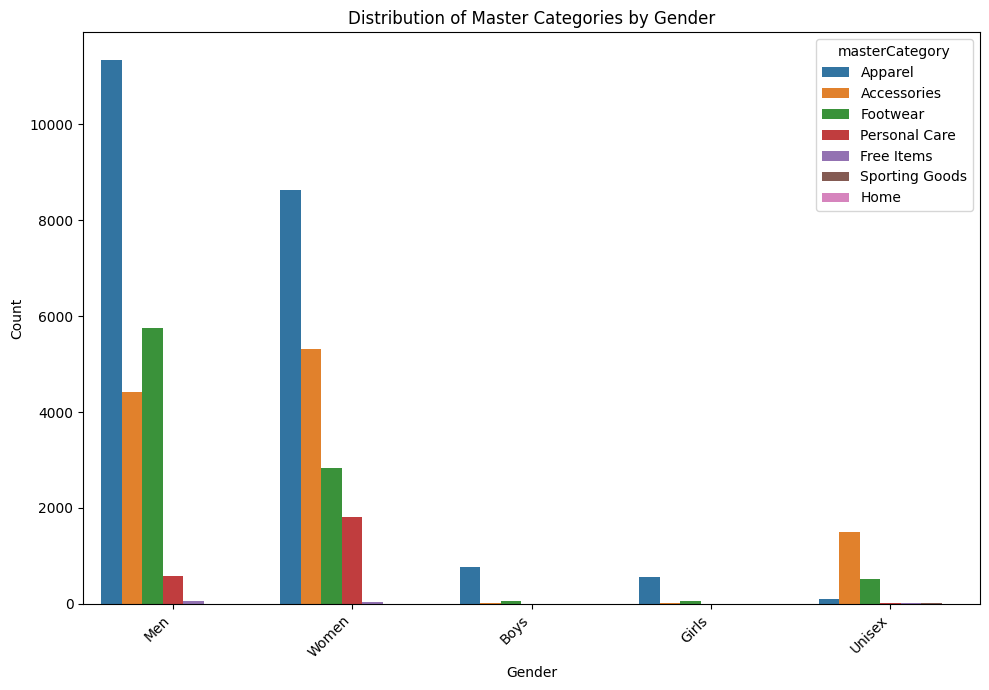

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(data=df, x='gender', hue='masterCategory')
plt.title('Distribution of Master Categories by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Master Categories by Gender:**

This plot shows which main product groups are most common for each gender.

*   **Clothing (Apparel) is most popular:** Men and Women mostly have clothing items in the dataset.
*   **Accessories and Shoes are also common:** These are also significant product groups for Men and Women, but less so than clothing.
*   **Unisex items are more balanced:** Products for both men and women show a more even mix of clothing, accessories, and shoes.
*   **Kids' items are mainly clothing and shoes:** Products for Boys and Girls are mostly clothing and footwear.
*   **Other items are less common:** Things like personal care, free items, sports gear, and home goods appear less often for all genders, especially for kids.

#### Analyze the distribution of Season by Gender

Let's see the distribution of seasons across different genders.

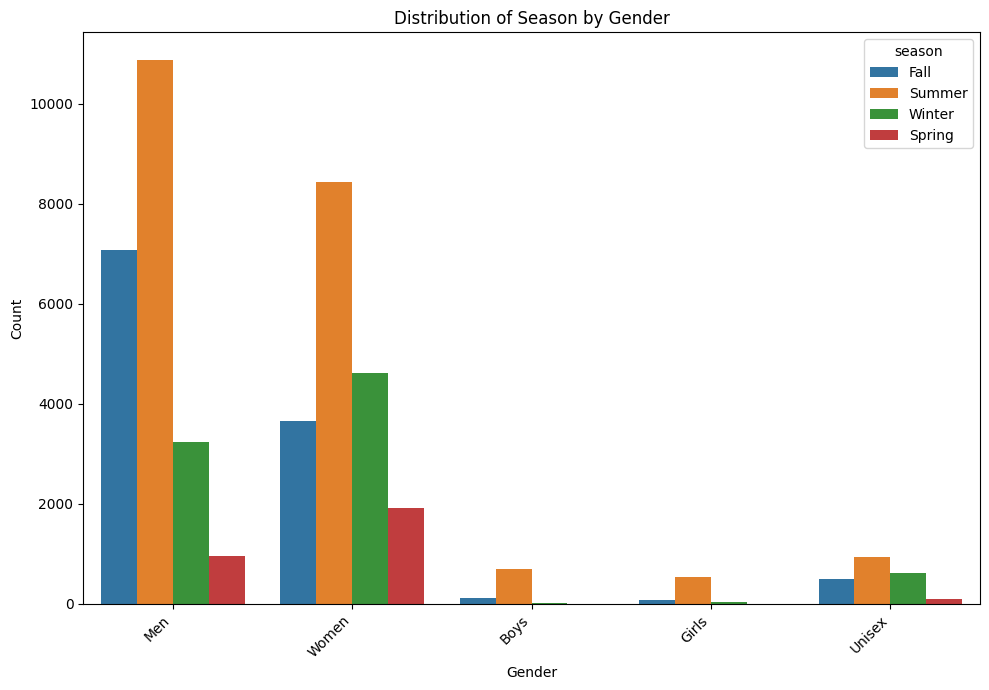

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(data=df, x='gender', hue='season')
plt.title('Distribution of Season by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Season by Gender:**

This plot shows how products for each gender are distributed across different seasons. 'Summer' is the most frequent season for all genders, followed by 'Fall' and 'Winter'. 'Spring' has the fewest products across all genders. The distribution pattern across seasons is similar for Men and Women, while Unisex, Boys, and Girls have fewer products overall but follow a similar trend with 'Summer' being the most prominent season.

#### Analyze the distribution of Article Type by Gender

Let's see the distribution of article types across different genders.

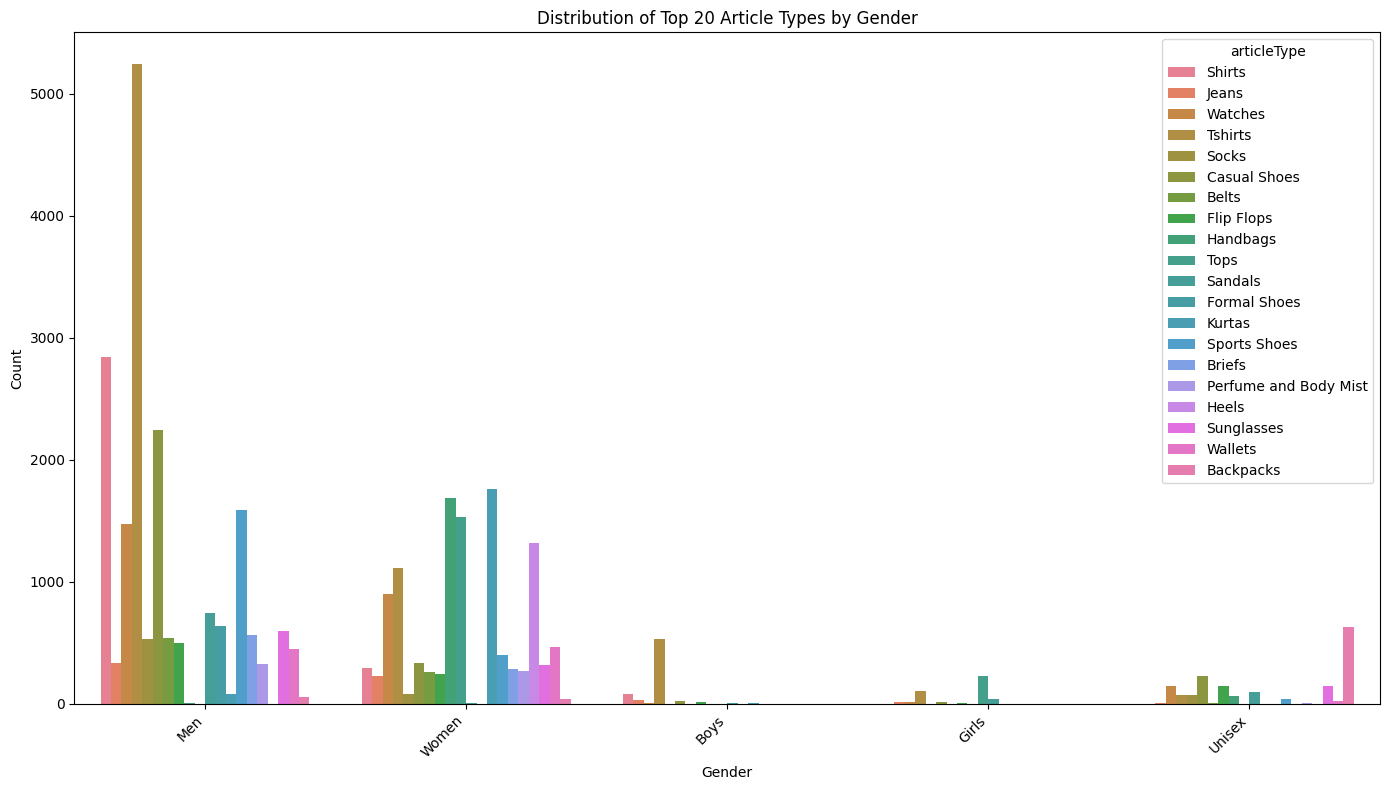

In [ ]:
# Get the top 20 article types
top_article_types = df['articleType'].value_counts().nlargest(20).index

# Filter the DataFrame to include only rows with top article types
df_top_article_types = df[df['articleType'].isin(top_article_types)]

plt.figure(figsize=(14, 8))
sns.countplot(data=df_top_article_types, x='gender', hue='articleType')
plt.title('Distribution of Top 20 Article Types by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Article Type by Gender:**

This plot shows the variety of article types available for each gender. 'Apparel' related article types like T-shirts and Shirts are prominent for Men and Women. Footwear like Casual Shoes and Sports Shoes are also common across genders. The plot reveals that Men and Women have a wider range of article types compared to Unisex, Boys, and Girls.

#### Analyze the distribution of Subcategory by Gender

Let's see the distribution of subcategories across different genders.

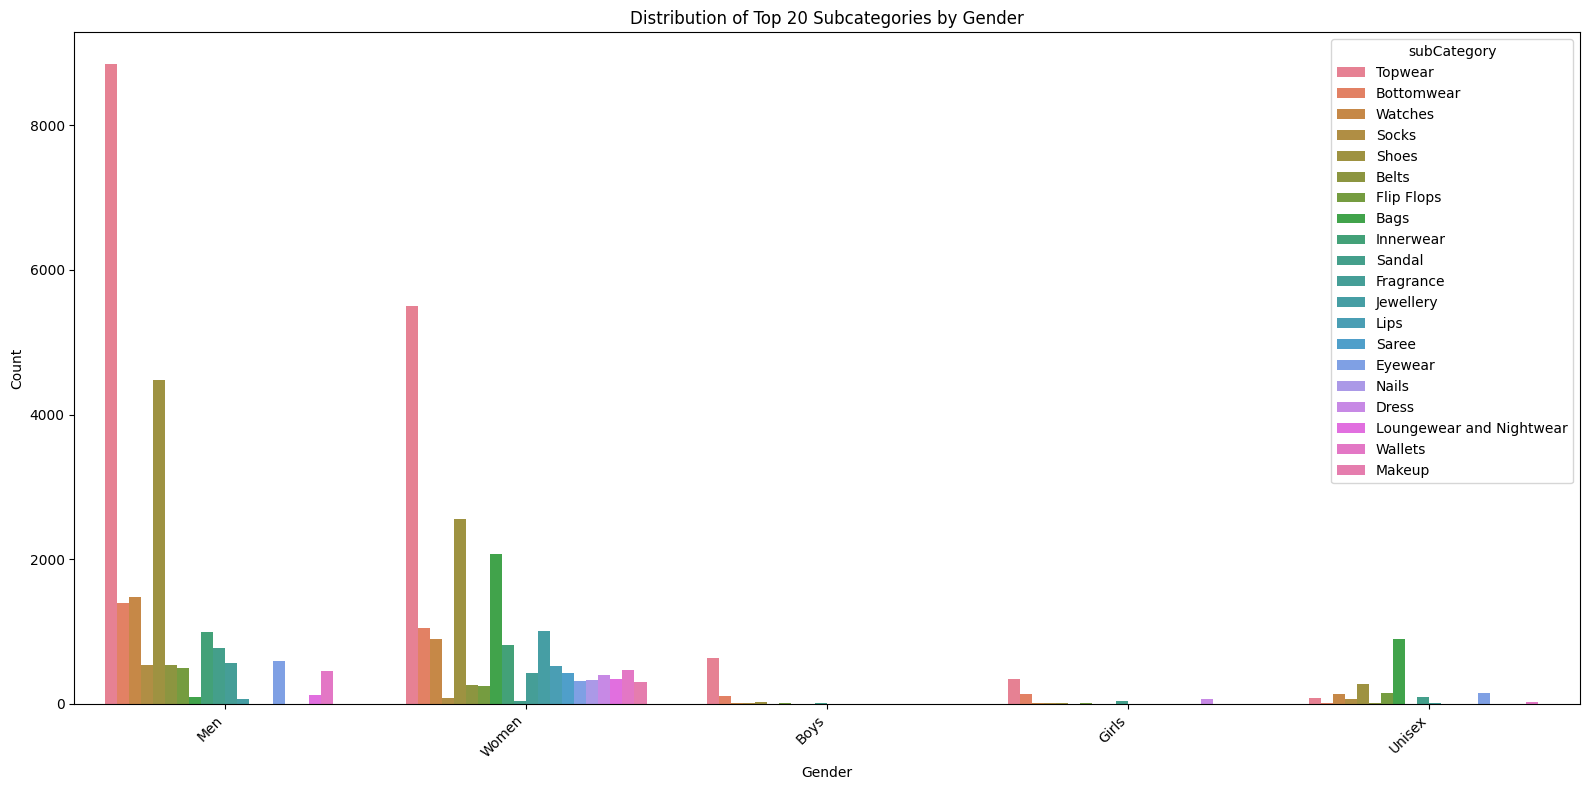

In [ ]:
# Get the top 20 subcategories
top_subcategories = df['subCategory'].value_counts().nlargest(20).index

# Filter the DataFrame to include only rows with top subcategories
df_top_subcategories = df[df['subCategory'].isin(top_subcategories)]

plt.figure(figsize=(16, 8))
sns.countplot(data=df_top_subcategories, x='gender', hue='subCategory')
plt.title('Distribution of Top 20 Subcategories by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Subcategory by Gender:**

This plot shows the distribution of different subcategories for each gender. 'Topwear' is the most common subcategory for both Men and Women. 'Shoes' and 'Bags' are also significant subcategories across genders. The plot highlights the diversity of subcategories available, with Men and Women having a wider range compared to Unisex, Boys, and Girls.

#### Analyze the distribution of Base Colour by Gender

Let's see the distribution of base colours across different genders.

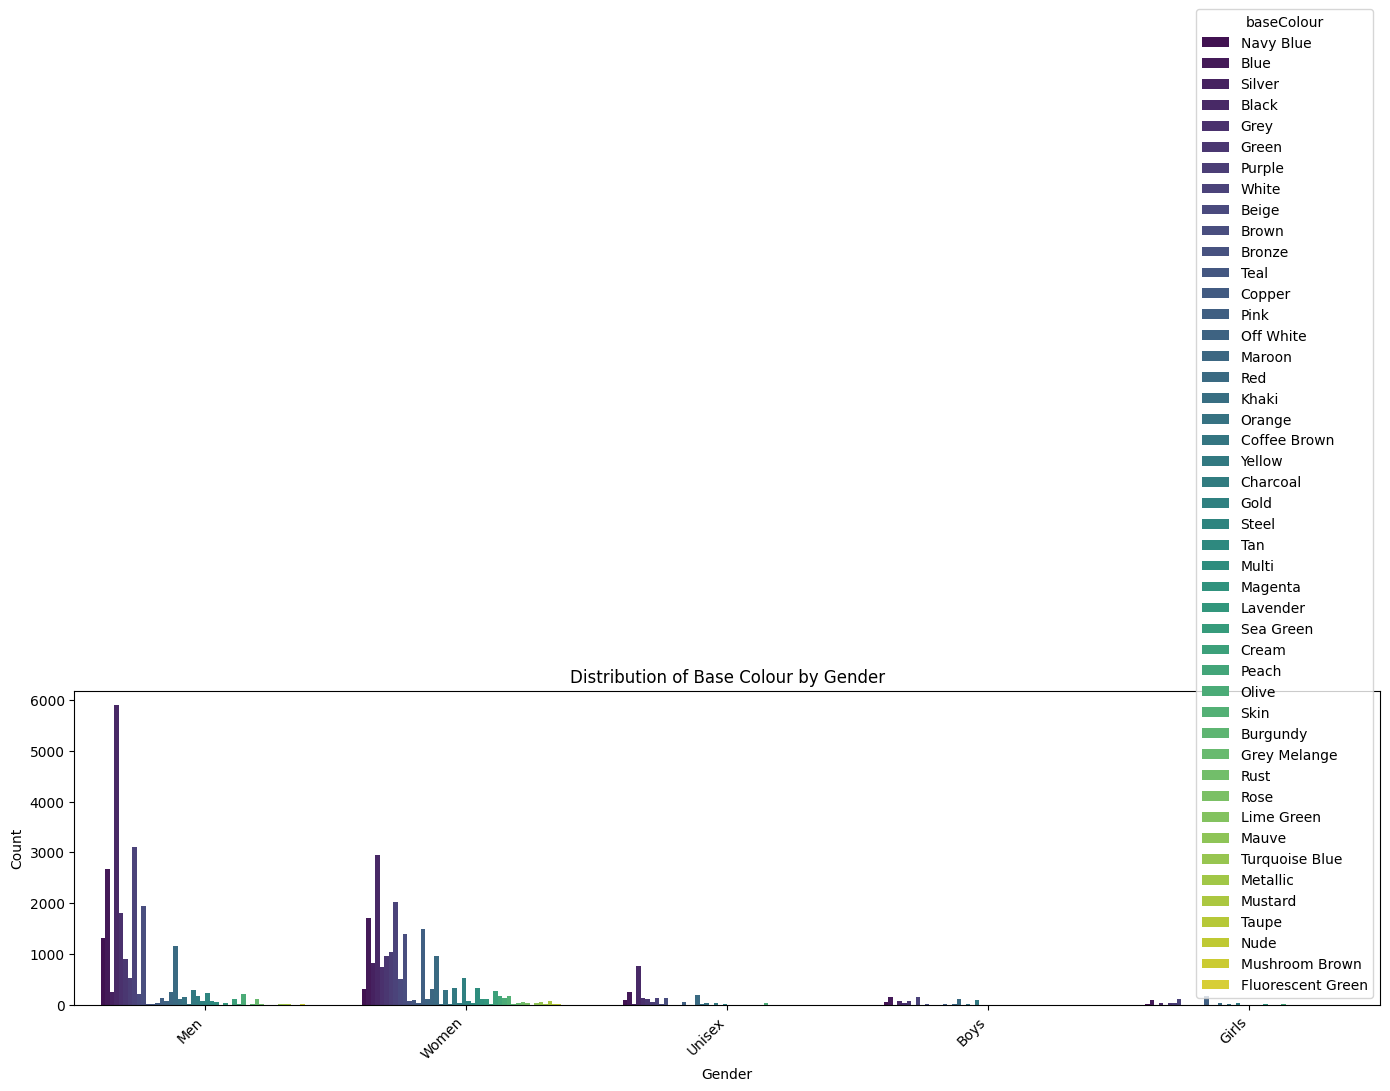

In [ ]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='gender', hue='baseColour', palette='viridis', order=df['gender'].value_counts().index)
plt.title('Distribution of Base Colour by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Base Colour by Gender:**

This plot shows which base colours are most common for each gender. Black, White, and Blue are frequently represented across Men and Women. The distribution of other colors varies, showing some gender preferences. Unisex, Boys, and Girls have a more limited range of base colours compared to Men and Women.

#### Analyze the distribution of Usage by Gender

Let's see the distribution of product usage across different genders.

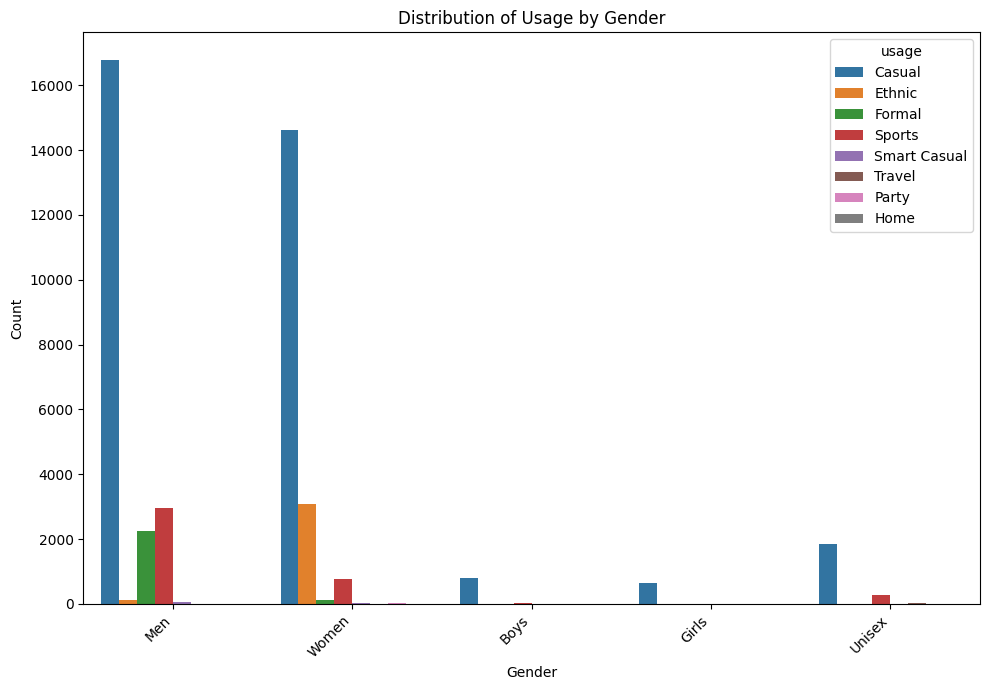

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(data=df, x='gender', hue='usage')
plt.title('Distribution of Usage by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Usage by Gender:**

This plot shows how different types of product usage are distributed across genders. 'Casual' usage is dominant for all genders, reflecting the overall distribution of the dataset. 'Sports', 'Ethnic', and 'Formal' usages are also represented, with variations in their proportions across genders. Other usage types like 'Smart Casual', 'Party', 'Travel', and 'Home' are less frequent for all genders.

#### Analyze the distribution of Gender by Season

Let's see the distribution of genders across different seasons.

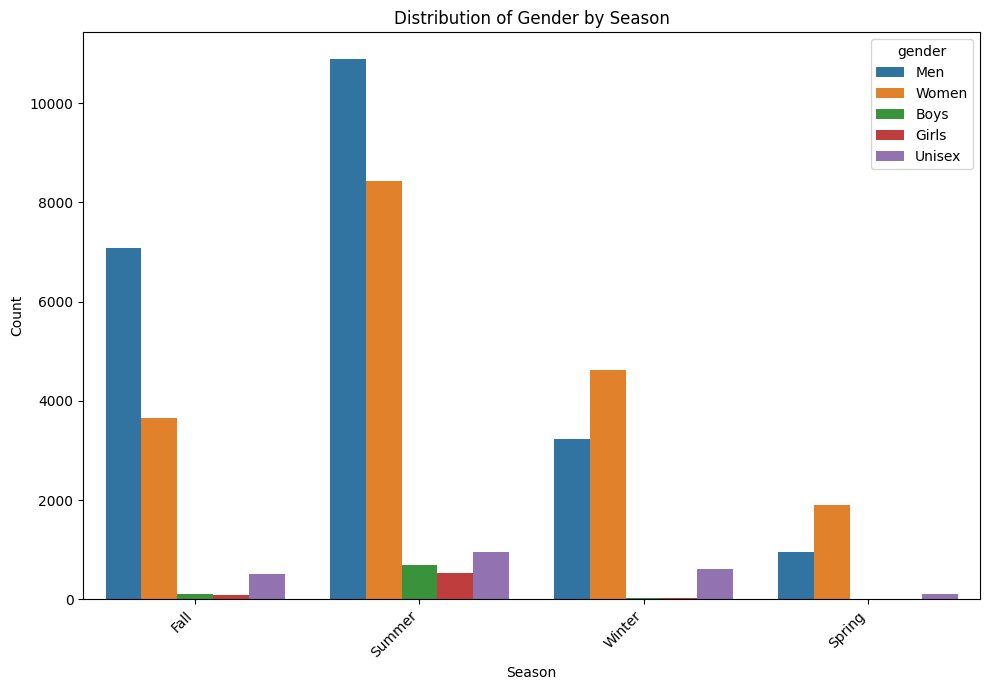

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(data=df, x='season', hue='gender')
plt.title('Distribution of Gender by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Gender by Season:**

This plot shows the distribution of genders within each season. 'Summer' has the highest count for all genders, especially Men and Women. The distribution across seasons is generally similar for Men and Women, with 'Summer' being the most popular, followed by 'Fall' and 'Winter', and then 'Spring'. Unisex, Boys, and Girls have fewer products overall but follow a similar seasonal trend.

#### Analyze the distribution of Master Categories by Season

Let's see the distribution of master categories across different seasons.

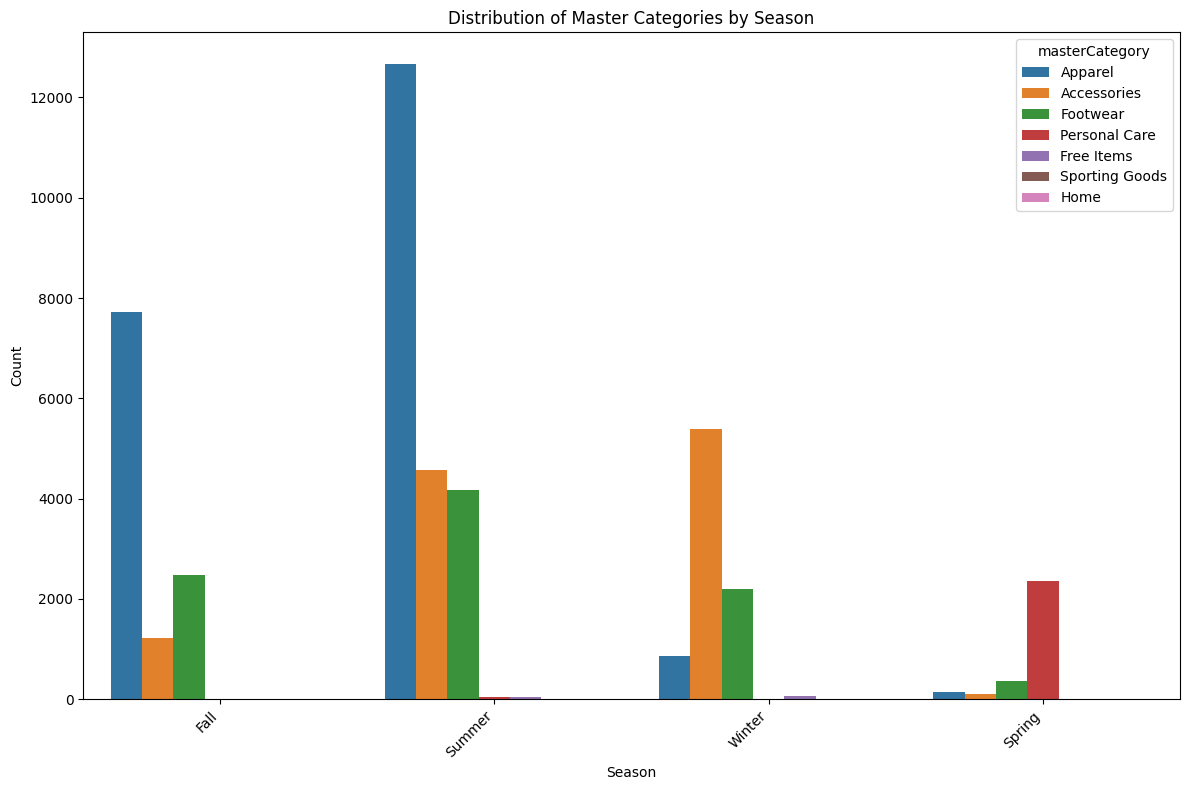

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='season', hue='masterCategory')
plt.title('Distribution of Master Categories by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Master Categories by Season:**

This plot shows how different master categories are distributed across the four seasons. 'Apparel', 'Accessories', and 'Footwear' are the most prominent categories in all seasons, with 'Apparel' being the highest. 'Summer' has the highest counts for all categories, reflecting the overall dataset distribution. Other categories like 'Personal Care', 'Free Items', 'Sporting Goods', and 'Home' have significantly fewer items across all seasons.

#### Analyze the distribution of Subcategories by Season

Let's see the distribution of subcategories across different seasons.

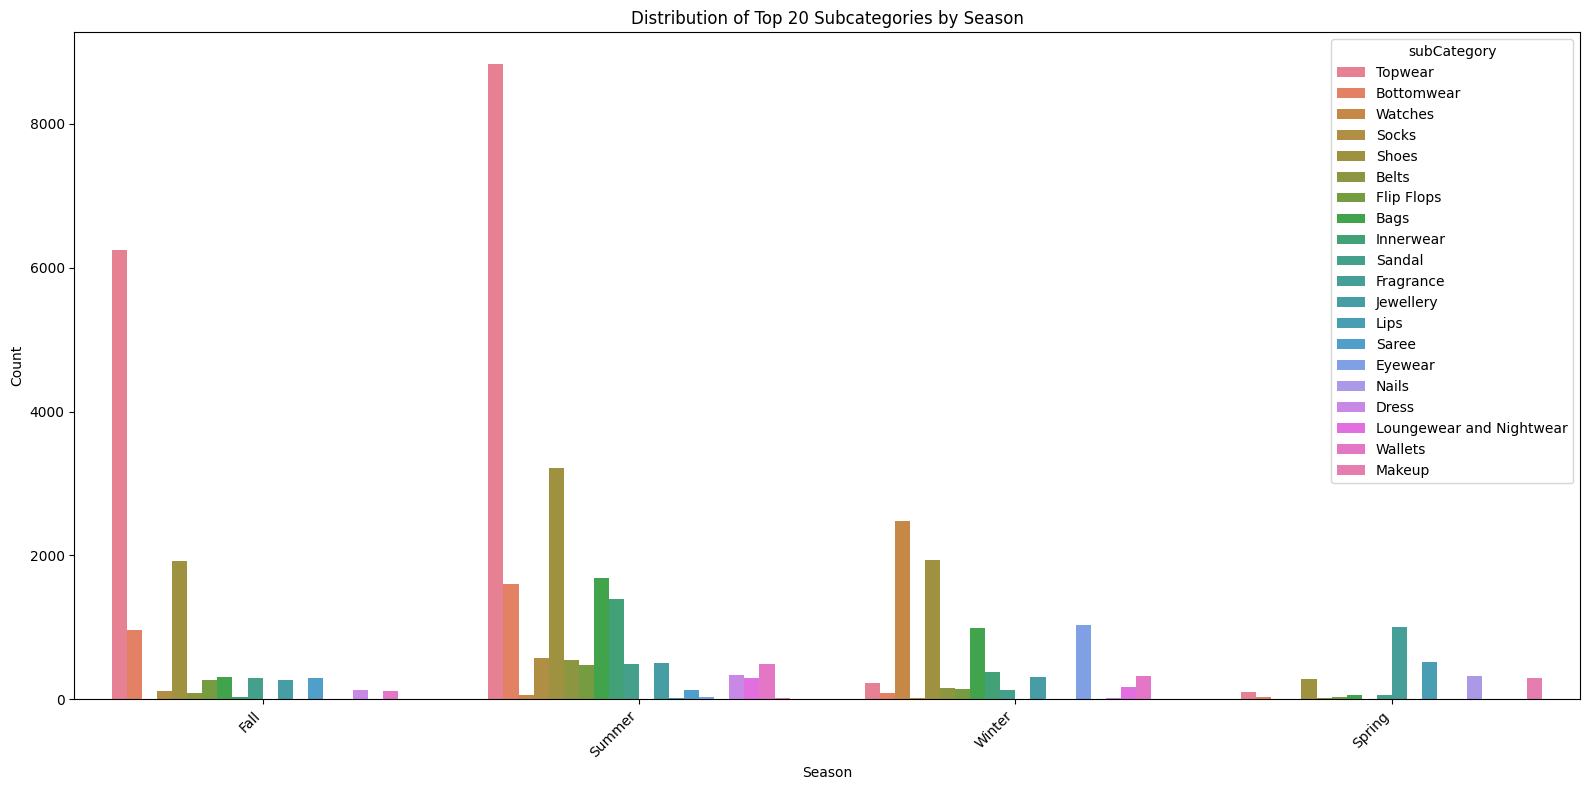

In [ ]:
# Get the top 20 subcategories for better visualization
top_subcategories = df['subCategory'].value_counts().nlargest(20).index

# Filter the DataFrame to include only rows with top subcategories
df_top_subcategories = df[df['subCategory'].isin(top_subcategories)]


plt.figure(figsize=(16, 8))
sns.countplot(data=df_top_subcategories, x='season', hue='subCategory')
plt.title('Distribution of Top 20 Subcategories by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Subcategories by Season:**

This plot shows the distribution of the top 20 subcategories across different seasons. 'Topwear', 'Shoes', and 'Bags' are generally the most frequent subcategories in all seasons, with 'Summer' having the highest counts for most. There are some variations in the proportions of other subcategories across seasons, suggesting some seasonal relevance for certain product types.

#### Analyze the distribution of Article Types by Season

Let's see the distribution of article types across different seasons.

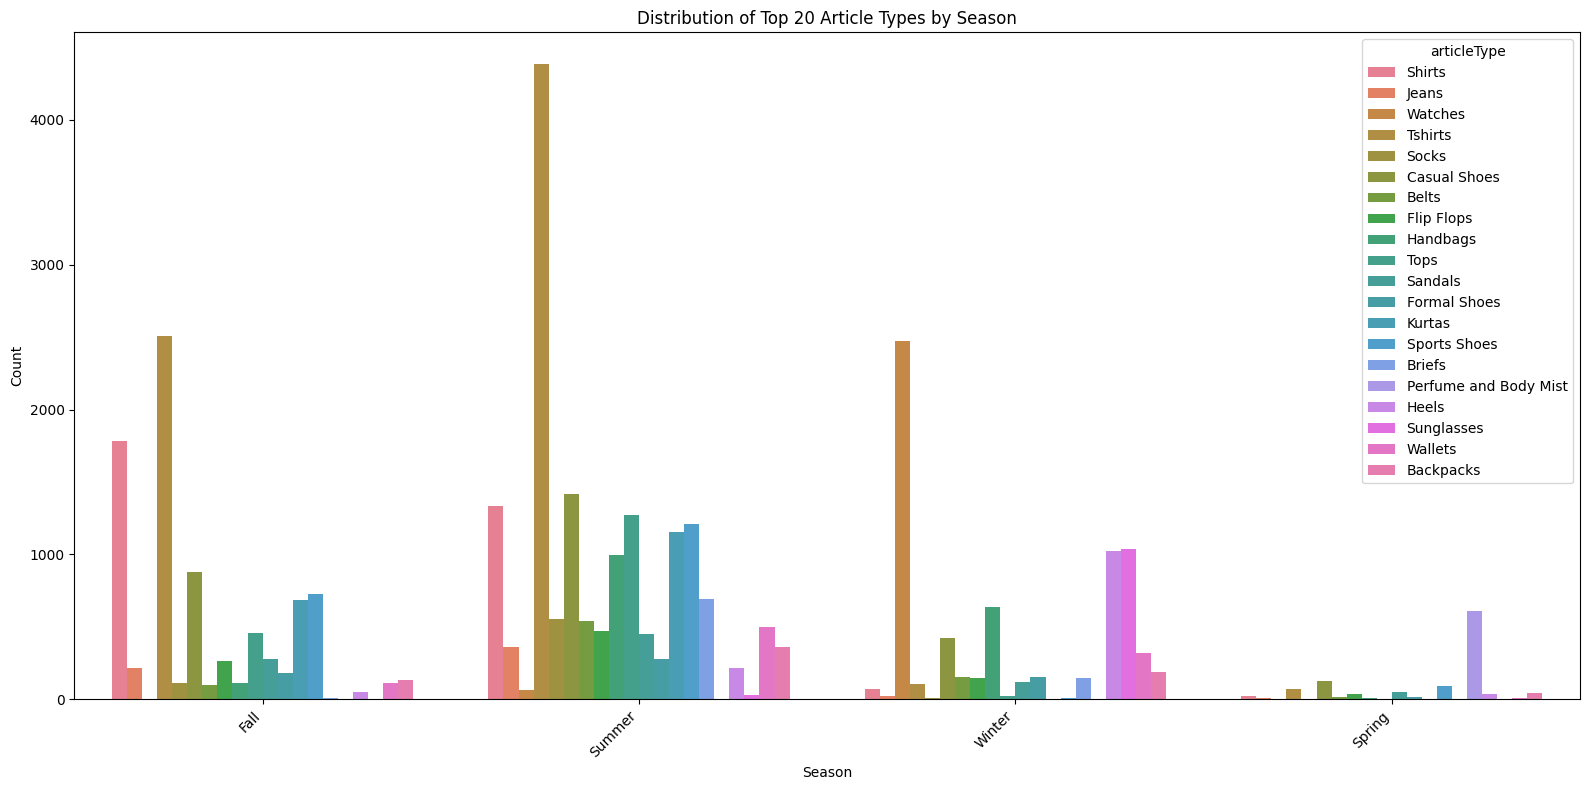

In [ ]:
# Get the top 20 article types for better visualization
top_article_types = df['articleType'].value_counts().nlargest(20).index

# Filter the DataFrame to include only rows with top article types
df_top_article_types = df[df['articleType'].isin(top_article_types)]

plt.figure(figsize=(16, 8))
sns.countplot(data=df_top_article_types, x='season', hue='articleType')
plt.title('Distribution of Top 20 Article Types by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Article Types by Season:**

This plot shows the distribution of the top 20 article types across different seasons. 'Tshirts', 'Shirts', and various types of footwear are common across seasons, with 'Summer' generally having the highest counts. There are some variations in the distribution of specific article types across seasons, suggesting seasonal preferences for certain clothing and footwear.

#### Analyze the distribution of Base Colour by Season

Let's see the distribution of base colours across different seasons.

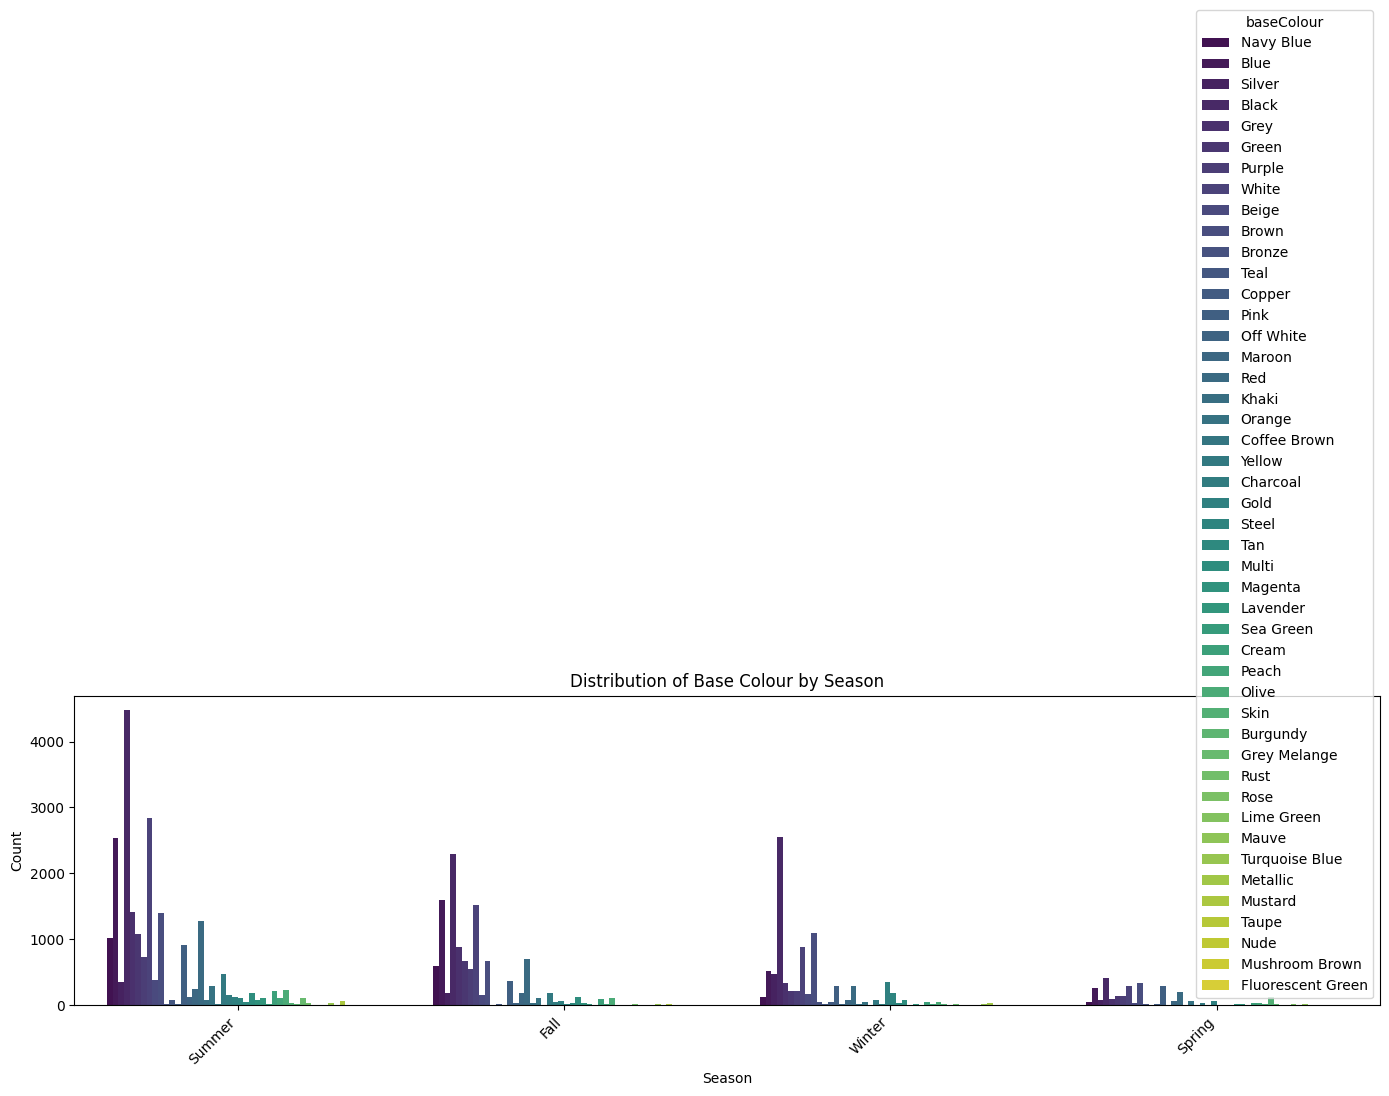

In [ ]:
plt.figure(figsize=(14, 8))
sns.countplot(data=df, x='season', hue='baseColour', palette='viridis', order=df['season'].value_counts().index)
plt.title('Distribution of Base Colour by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Base Colour by Season:**

This plot shows the distribution of base colours across different seasons. Black, White, and Blue are common base colours in all seasons, with 'Summer' having the highest counts for most colours. There are some variations in the distribution of other colours across seasons, suggesting some seasonal preferences or trends in base colours.

#### Analyze the distribution of Usage by Season

Let's see the distribution of product usage across different seasons.

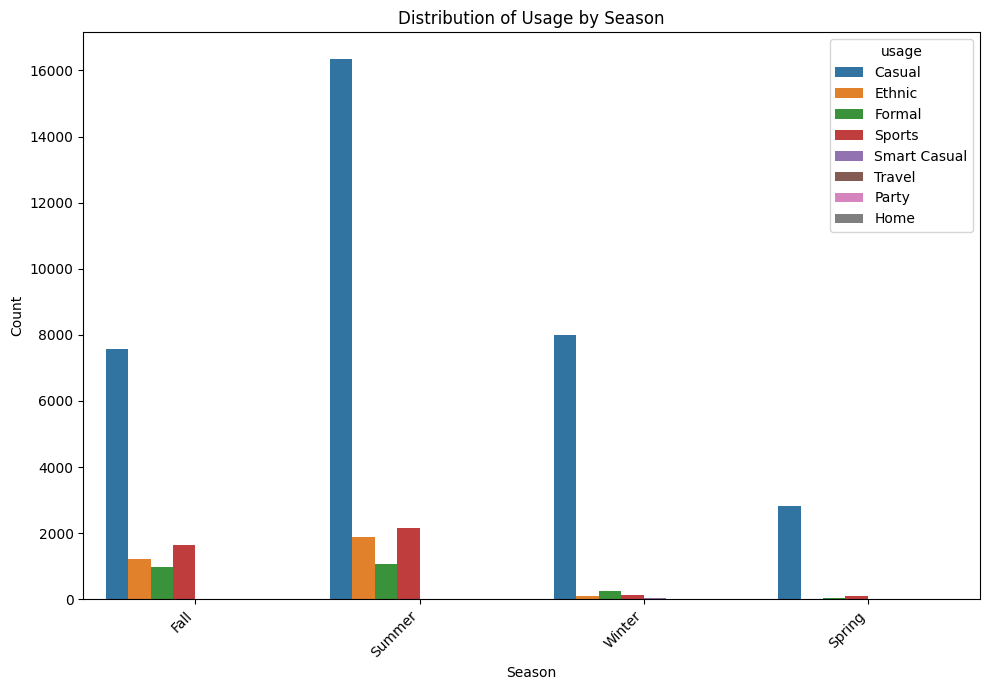

In [ ]:
plt.figure(figsize=(10, 7))
sns.countplot(data=df, x='season', hue='usage')
plt.title('Distribution of Usage by Season')
plt.xlabel('Season')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Usage by Season:**

This plot shows how different types of product usage are distributed across seasons. 'Casual' usage is dominant in all seasons, reflecting the overall distribution of the dataset. 'Sports', 'Ethnic', and 'Formal' usages are also represented, with variations in their proportions across seasons. Other usage types like 'Smart Casual', 'Party', 'Travel', and 'Home' are less frequent in all seasons.

#### Analyze relationships between mastercategory and usage


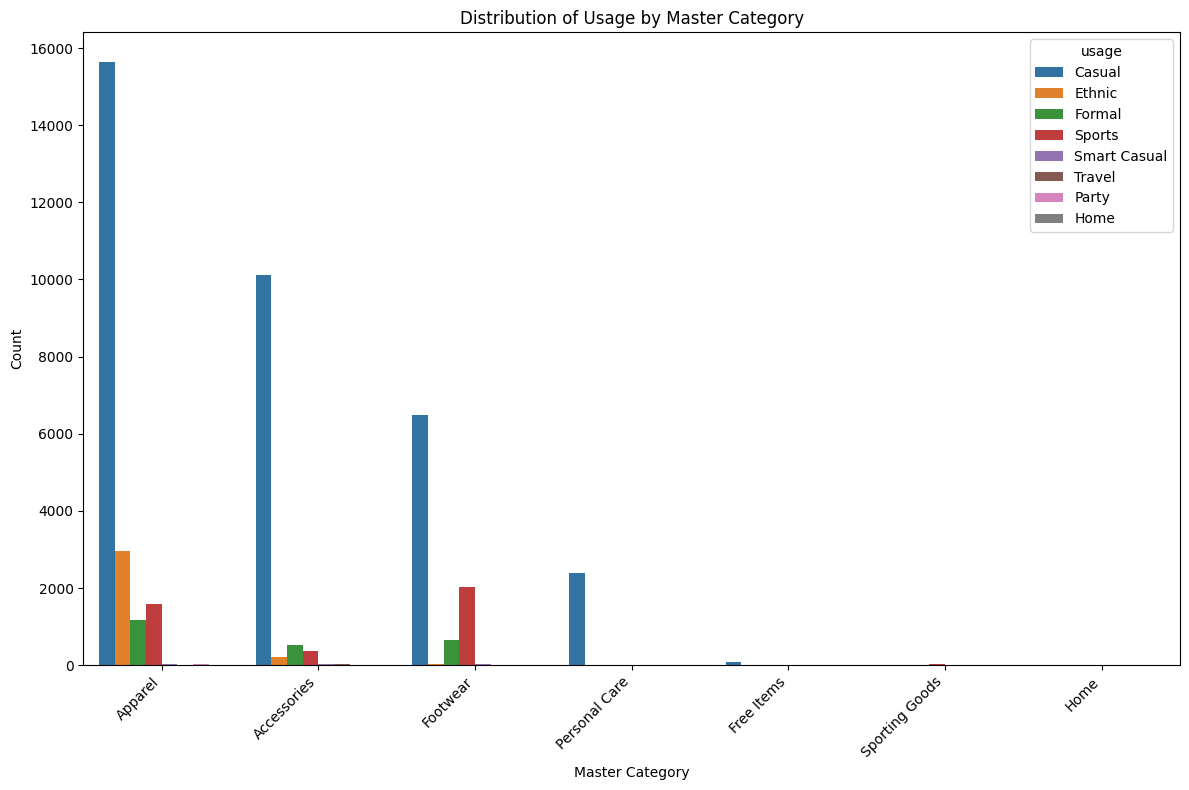

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='masterCategory', hue='usage')
plt.title('Distribution of Usage by Master Category')
plt.xlabel('Master Category')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Usage by Master Category:**

This plot shows how different types of product usage are distributed across master categories. 'Casual' usage is dominant across most master categories, especially 'Apparel', 'Accessories', and 'Footwear'. 'Sports' usage is primarily associated with 'Footwear' and 'Apparel'. 'Ethnic' usage is mainly seen in 'Apparel'. 'Formal' usage is also present in 'Apparel' and 'Footwear'. Other usage types are less frequent across all master categories.

#### Analyze relationships between subcategory and usage



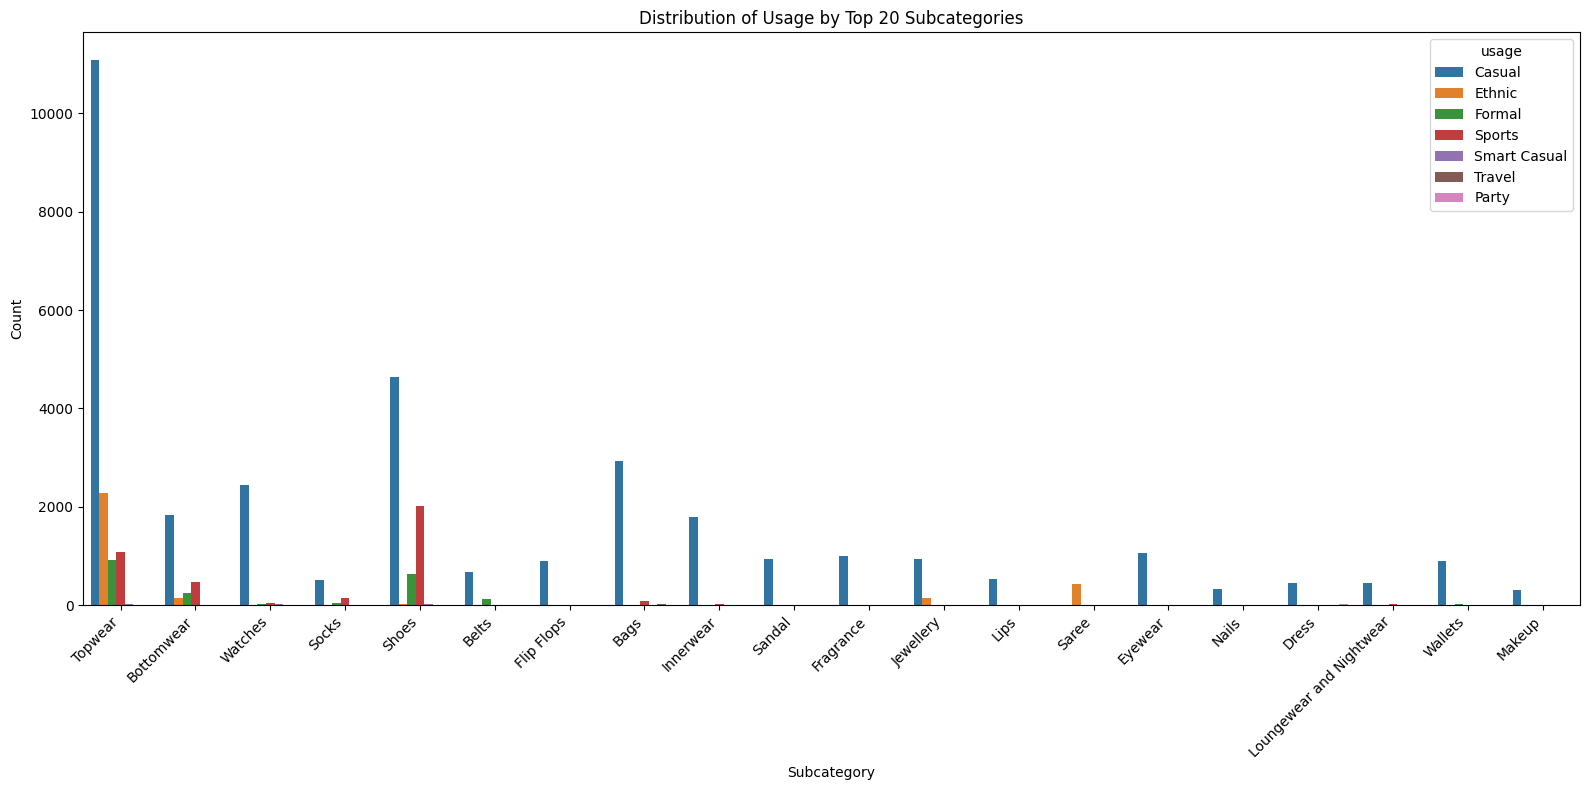

In [ ]:
top_subcategories = df['subCategory'].value_counts().nlargest(20).index
df_top_subcategories = df[df['subCategory'].isin(top_subcategories)]

plt.figure(figsize=(16, 8))
sns.countplot(data=df_top_subcategories, x='subCategory', hue='usage')
plt.title('Distribution of Usage by Top 20 Subcategories')
plt.xlabel('Subcategory')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Usage by Top 20 Subcategories:**

This plot shows the distribution of different usage types within the top 20 subcategories. 'Casual' usage is prevalent across almost all top subcategories, especially in 'Topwear', 'Shoes', and 'Bags'. 'Sports' usage is noticeably high in 'Shoes' and 'Socks'. 'Ethnic' usage is concentrated in 'Kurtas' and 'Saree'. 'Formal' usage is significant in 'Shirts' and 'Wallets'. The plot reveals how product usage varies depending on the specific subcategory.

#### Analyze trends over time for mastercategory


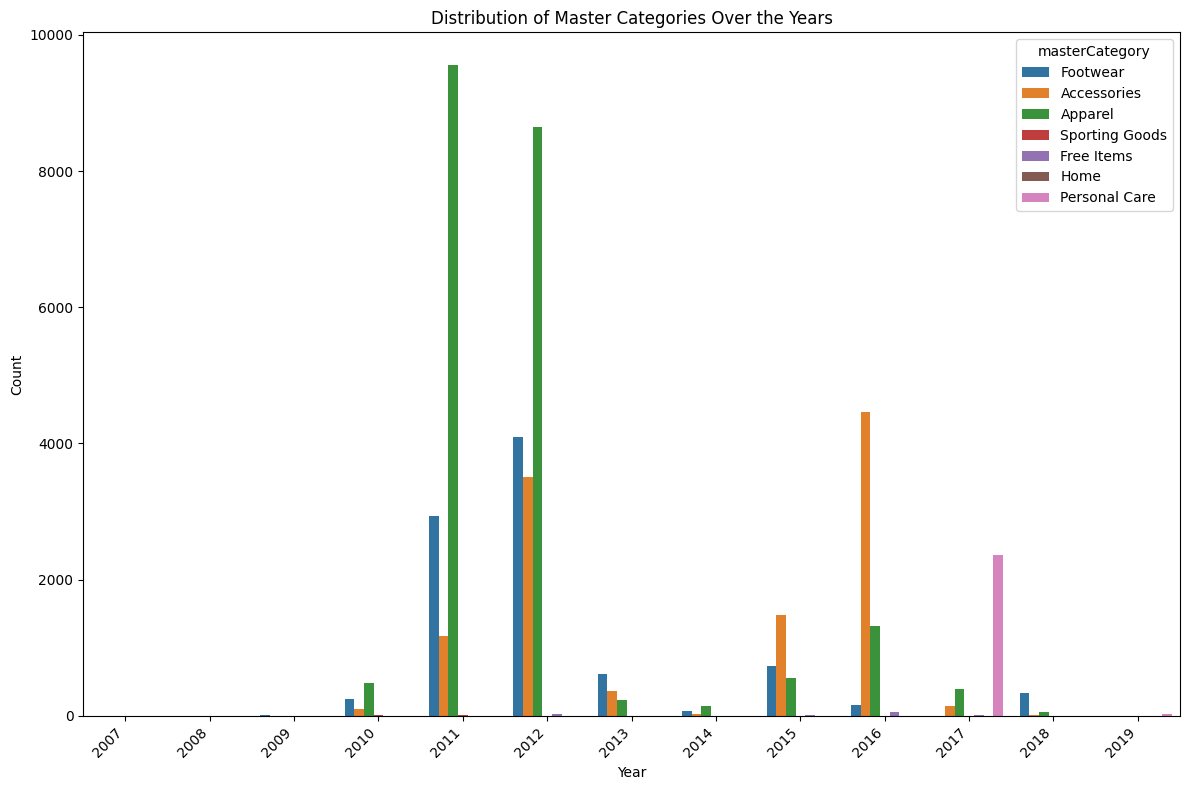

In [ ]:
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='year', hue='masterCategory')
plt.title('Distribution of Master Categories Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Master Categories Over the Years:**

This plot shows how the distribution of master categories has changed over the years. 'Apparel' is consistently the most dominant master category across all years with data. 'Accessories' and 'Footwear' also maintain a significant presence. The overall trend for most categories seems to follow the general distribution of the dataset over time, with peaks in 2011 and 2012 and a decline thereafter. The representation of less frequent categories like 'Personal Care', 'Free Items', 'Sporting Goods', and 'Home' remains relatively low throughout the years.

#### Analyze trends over time for articletype
Investigate the popularity of key article types over the years.


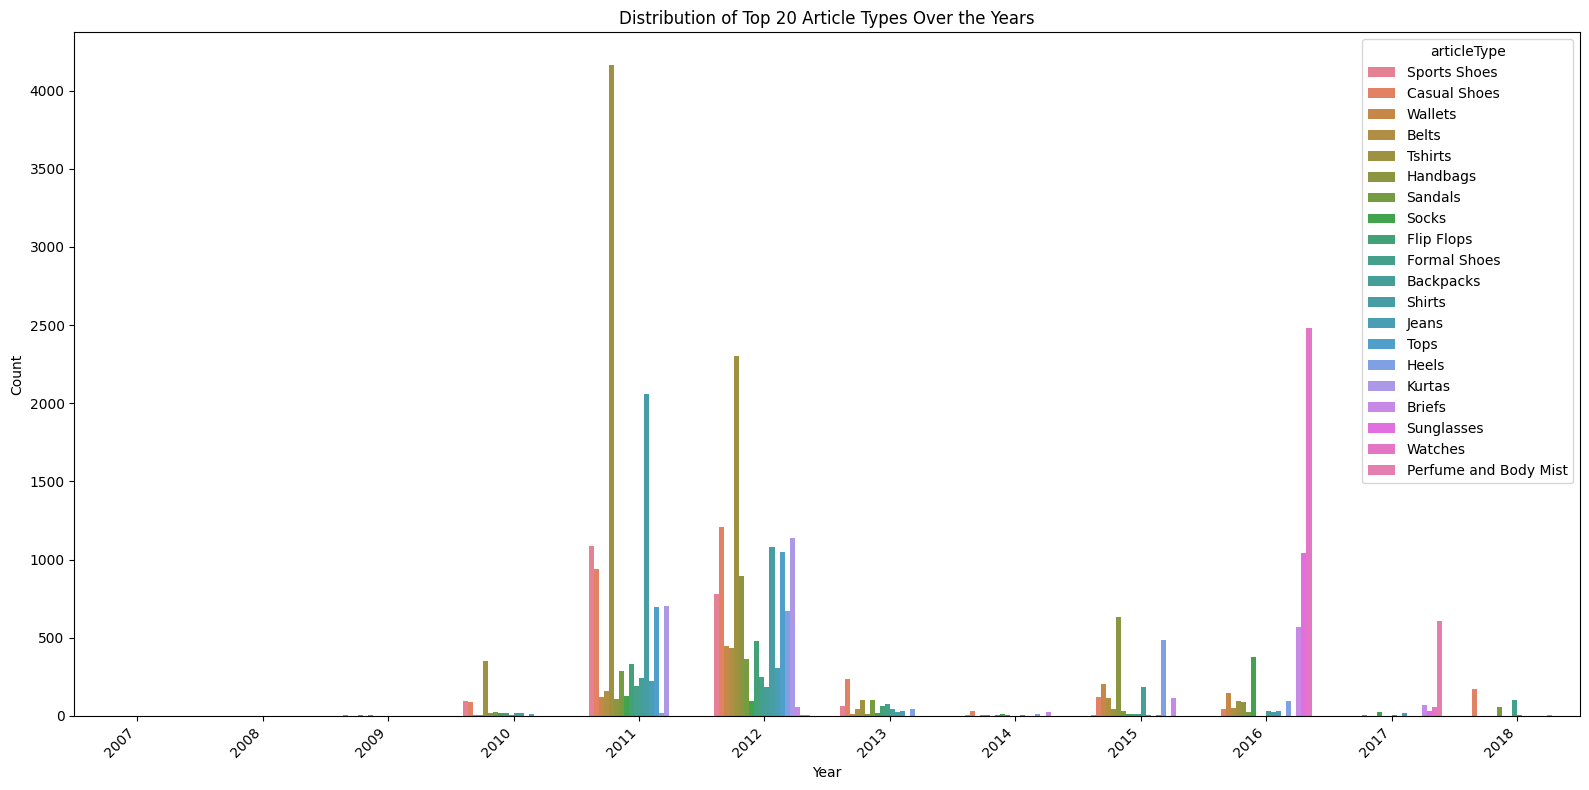

In [ ]:
top_article_types = df['articleType'].value_counts().nlargest(20).index
df_top_article_types = df[df['articleType'].isin(top_article_types)]

plt.figure(figsize=(16, 8))
sns.countplot(data=df_top_article_types, x='year', hue='articleType')
plt.title('Distribution of Top 20 Article Types Over the Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

**Analysis of Top 20 Article Types Over the Years:**

This plot illustrates the trends in popularity of the top 20 article types over the years. 'Tshirts' and 'Shirts' are consistently among the most frequent article types, peaking in 2011 and 2012. Various types of footwear like 'Casual Shoes' and 'Sports Shoes' also show strong presence and similar temporal trends. The plot allows us to observe the rise and fall in the number of products for specific article types over time, reflecting potential shifts in fashion trends or product availability in the dataset.

## Build a Deep learning model
Develop a deep learning model using a large dataset of images.

In [ ]:
print("First 5 rows of the DataFrame:")
display(df.head())

print("\nDataFrame Info:")
df.info()

print("\nDescriptive Statistics:")
display(df.describe())

First 5 rows of the DataFrame:


,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,filename,link,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,15970.jpg,http://assets.myntassets.com/v1/images/style/p...,/root/.cache/kagglehub/datasets/paramaggarwal/...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,39386.jpg,http://assets.myntassets.com/v1/images/style/p...,/root/.cache/kagglehub/datasets/paramaggarwal/...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,59263.jpg,http://assets.myntassets.com/v1/images/style/p...,/root/.cache/kagglehub/datasets/paramaggarwal/...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,21379.jpg,http://assets.myntassets.com/v1/images/style/p...,/root/.cache/kagglehub/datasets/paramaggarwal/...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,53759.jpg,http://assets.myntassets.com/v1/images/style/p...,/root/.cache/kagglehub/datasets/paramaggarwal/...



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 44417 entries, 0 to 44423
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  44417 non-null  int64 
 1   gender              44417 non-null  object
 2   masterCategory      44417 non-null  object
 3   subCategory         44417 non-null  object
 4   articleType         44417 non-null  object
 5   baseColour          44417 non-null  object
 6   season              44417 non-null  object
 7   year                44417 non-null  int64 
 8   usage               44417 non-null  object
 9   productDisplayName  44417 non-null  object
 10  filename            44417 non-null  object
 11  link                44417 non-null  object
 12  image_path          44417 non-null  object
dtypes: int64(2), object(11)
memory usage: 4.7+ MB

Descriptive Statistics:


,id,year
count,44417.000000,44417.000000
mean,29694.660310,2012.806043
std,17050.145672,2.126155
min,1163.000000,2007.000000
25%,14767.000000,2011.000000
50%,28615.000000,2012.000000
75%,44683.000000,2015.000000
max,60000.000000,2019.000000


## Data preparation

Load and preprocess the image data (resizing, normalization). Prepare the labels for each of the four outputs (Color, Article Type, Season, Gender) by encoding the categorical labels into a suitable numerical format. Split the data into training, validation, and test sets. Create data generators or pipelines for efficient loading and augmentation of images during training, considering the large dataset size.




In [22]:
# Define image dimensions
IMG_HEIGHT = 128
IMG_WIDTH = 128

# Prepare labels for encoding
base_colour_labels = df['baseColour'].tolist()
article_type_labels = df['articleType'].tolist()
season_labels = df['season'].tolist()
gender_labels = df['gender'].tolist()

# Encode labels
label_encoders = {
    'baseColour': LabelEncoder().fit(base_colour_labels),
    'articleType': LabelEncoder().fit(article_type_labels),
    'season': LabelEncoder().fit(season_labels),
    'gender': LabelEncoder().fit(gender_labels)
}

# Split data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

# Replace original string columns with encoded integer labels in train_df and val_df
train_df['baseColour_encoded'] = label_encoders['baseColour'].transform(train_df['baseColour'])
train_df['articleType_encoded'] = label_encoders['articleType'].transform(train_df['articleType'])
train_df['season_encoded'] = label_encoders['season'].transform(train_df['season'])
train_df['gender_encoded'] = label_encoders['gender'].transform(train_df['gender'])

val_df['baseColour_encoded'] = label_encoders['baseColour'].transform(val_df['baseColour'])
val_df['articleType_encoded'] = label_encoders['articleType'].transform(val_df['articleType'])
val_df['season_encoded'] = label_encoders['season'].transform(val_df['season'])
val_df['gender_encoded'] = label_encoders['gender'].transform(val_df['gender'])


# Create ImageDataGenerators
datagen = ImageDataGenerator(rescale=1./255.)

# create training data

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=BASE_PATH + '/images/', # directory to the image path
    x_col='filename',
    y_col=['baseColour_encoded', 'articleType_encoded', 'season_encoded', 'gender_encoded'],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='multi_output', # multi_output for multiple output columns

)

# create the validation data
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=BASE_PATH + '/images/',
    x_col='filename',
    y_col=['baseColour_encoded', 'articleType_encoded', 'season_encoded', 'gender_encoded'],
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=32,
    class_mode='multi_output',
)

print("Data preparation complete using ImageDataGenerator.")

Found 35529 validated image filenames.
Found 8883 validated image filenames.
Data preparation complete using ImageDataGenerator.


### Build the multi-output model using transfer learning (VGG16)

In [23]:
# Input layer
input_tensor = Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

# Load pre-trained VGG16 model, excluding the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=input_tensor)

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = Dense(256, activation='relu')(x) # Added another dense layer

# Output layers for each task
num_base_colours = len(label_encoders['baseColour'].classes_)
num_article_types = len(label_encoders['articleType'].classes_)
num_seasons = len(label_encoders['season'].classes_)
num_genders = len(label_encoders['gender'].classes_)


output_base_colour = Dense(num_base_colours, activation='softmax', name='baseColour')(x)
output_article_type = Dense(num_article_types, activation='softmax', name='articleType')(x)
output_season = Dense(num_seasons, activation='softmax', name='season')(x)
output_gender = Dense(num_genders, activation='softmax', name='gender')(x)

# Create the multi-output model
model = Model(inputs=base_model.input, outputs=[output_base_colour, output_article_type, output_season, output_gender])

# Compile the model
model.compile(optimizer='adam',
              loss={'baseColour': 'sparse_categorical_crossentropy',
                    'articleType': 'sparse_categorical_crossentropy',
                    'season': 'sparse_categorical_crossentropy',
                    'gender': 'sparse_categorical_crossentropy'},
              metrics={'baseColour': 'accuracy',
                       'articleType': 'accuracy',
                       'season': 'accuracy',
                       'gender': 'accuracy'})

model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 128, 128,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 64, 64,    │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 64, 64,    │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 64, 64,    │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 32, 32,    │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 32, 32,    │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 32, 32,    │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 32, 32,    │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 16, 16,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 16, 16,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 16, 16,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 16, 16,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 8, 8, 512) │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 8, 8, 512) │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 8, 8, 512) │  2,359,808 │ block5_conv1[0][

 Total params: 19,091,718 (72.83 MB)

 Trainable params: 4,377,030 (16.70 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

### Model Training with multiple output

In [24]:

# Custom generator to yield data in the format expected by the multi-output model
class MultiOutputDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, generator, output_names):
        self.generator = generator
        self.output_names = output_names

    def __len__(self):
        return len(self.generator)

    def __getitem__(self, index):
        # get a batch from the underlying generator
        batch_x, batch_y = self.generator[index]

        # restructure the labels into a dictionary mapped by output names
        batch_y_dict = {name: batch_y[i] for i, name in enumerate(self.output_names)}

        return batch_x, batch_y_dict

# output layer labels
output_layer_names = ['baseColour', 'articleType', 'season', 'gender']

# custom generators to create multiple output layer
custom_train_generator = MultiOutputDataGenerator(train_generator, output_layer_names)
custom_val_generator = MultiOutputDataGenerator(val_generator, output_layer_names)



# set callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

# Train the model
history = model.fit(
    custom_train_generator,
    steps_per_epoch=len(custom_train_generator),
    epochs=10,
    validation_data=custom_val_generator,
    validation_steps=len(custom_val_generator),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/5
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 1205s 1s/step - articleType_accuracy: 0.6384 - articleType_loss: 1.5091 - baseColour_accuracy: 0.3733 - baseColour_loss: 2.2867 - gender_accuracy: 0.8080 - gender_loss: 0.5158 - loss: 5.1827 - season_accuracy: 0.6216 - season_loss: 0.8704 - val_articleType_accuracy: 0.7941 - val_articleType_loss: 0.6918 - val_baseColour_accuracy: 0.4796 - val_baseColour_loss: 1.8134 - val_gender_accuracy: 0.8803 - val_gender_loss: 0.3319 - val_loss: 3.5706 - val_season_accuracy: 0.6825 - val_season_loss: 0.7344 - learning_rate: 0.0010
Epoch 2/5
1111/1111 ━━━━━━━━━━━━━━━━━━━━ 1113s 984ms/step - articleType_accuracy: 0.8130 - articleType_loss: 0.6166 - baseColour_accuracy: 0.5032 - baseColour_loss: 1.6895 - gender_accuracy: 0.8807 - gender_loss: 0.3249 - loss: 3.3350 - season_accuracy: 0.6996 - season_loss: 0.7039 - val_articleType_accuracy: 0.8167 - val_articleType_loss: 0.6084 - val_baseColour_accuracy: 0.5223 - val_baseColour_loss: 1.6234 - val_gender_accuracy:

## Save the model weights

In [25]:
model.save('fashion_images_model.h5')

### Test the model with new image downloaded from the amazon fashions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted attributes for the image '/content/shirt.jpg':
Base Colour: Blue
Article Type: Tops
Season: Summer
Gender: Women


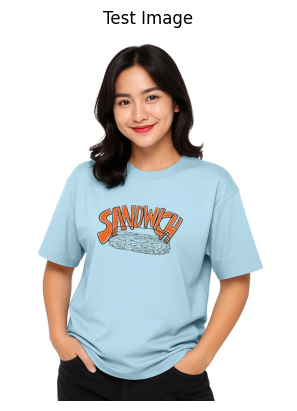

In [30]:

# Define a function to preprocess a single image
def preprocess_image(img_path, target_size):
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0
    return img_array

# Define a function to make predictions on a new image
def predict_image_attributes(model, img_path, label_encoders, target_size=(IMG_HEIGHT, IMG_WIDTH)):

    preprocessed_img = preprocess_image(img_path, target_size)

    # Make predictions using the model
    predictions = model.predict(preprocessed_img)

    # Decode the predictions back to original labels
    predicted_base_colour_encoded = np.argmax(predictions[0], axis=1)[0]
    predicted_article_type_encoded = np.argmax(predictions[1], axis=1)[0]
    predicted_season_encoded = np.argmax(predictions[2], axis=1)[0]
    predicted_gender_encoded = np.argmax(predictions[3], axis=1)[0]


    predicted_base_colour = label_encoders['baseColour'].inverse_transform([predicted_base_colour_encoded])[0]
    predicted_article_type = label_encoders['articleType'].inverse_transform([predicted_article_type_encoded])[0]
    predicted_season = label_encoders['season'].inverse_transform([predicted_season_encoded])[0]
    predicted_gender = label_encoders['gender'].inverse_transform([predicted_gender_encoded])[0]


    return {
        'baseColour': predicted_base_colour,
        'articleType': predicted_article_type,
        'season': predicted_season,
        'gender': predicted_gender
    }


test_image_path = '/content/shirt.jpg'

# Make a prediction
predicted_attributes = predict_image_attributes(model, test_image_path, label_encoders)

print(f"Predicted attributes for the image '{test_image_path}':")
print(f"Base Colour: {predicted_attributes['baseColour']}")
print(f"Article Type: {predicted_attributes['articleType']}")
print(f"Season: {predicted_attributes['season']}")
print(f"Gender: {predicted_attributes['gender']}")

# Display the image
img = Image.open(test_image_path)
plt.imshow(img)
plt.title("Test Image")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predicted attributes for the image '/content/slippers.jpg':
Base Colour: Brown
Article Type: Jewellery Set
Season: Summer
Gender: Women


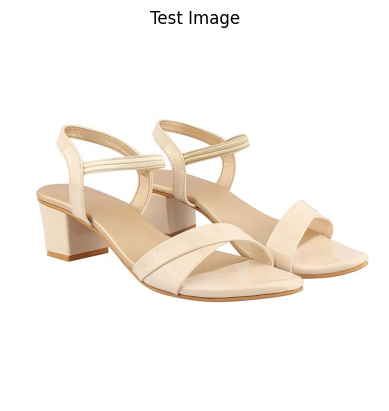

In [31]:
test_image_path = '/content/slippers.jpg'


predicted_attributes = predict_image_attributes(model, test_image_path, label_encoders)

print(f"Predicted attributes for the image '{test_image_path}':")
print(f"Base Colour: {predicted_attributes['baseColour']}")
print(f"Article Type: {predicted_attributes['articleType']}")
print(f"Season: {predicted_attributes['season']}")
print(f"Gender: {predicted_attributes['gender']}")

# Display the image
img = Image.open(test_image_path)
plt.imshow(img)
plt.title("Test Image")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Predicted attributes for the image '/content/watch.jpg':
Base Colour: Black
Article Type: Watches
Season: Winter
Gender: Men


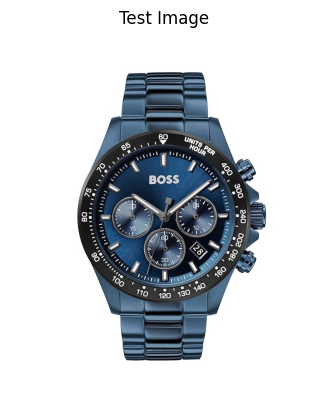

In [32]:
test_image_path = '/content/watch.jpg'

predicted_attributes = predict_image_attributes(model, test_image_path, label_encoders)

print(f"Predicted attributes for the image '{test_image_path}':")
print(f"Base Colour: {predicted_attributes['baseColour']}")
print(f"Article Type: {predicted_attributes['articleType']}")
print(f"Season: {predicted_attributes['season']}")
print(f"Gender: {predicted_attributes['gender']}")

# Display the image
img = Image.open(test_image_path)
plt.imshow(img)
plt.title("Test Image")
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
Predicted attributes for the image '/content/shirtss.jpg':
Base Colour: Grey
Article Type: Shirts
Season: Fall
Gender: Men


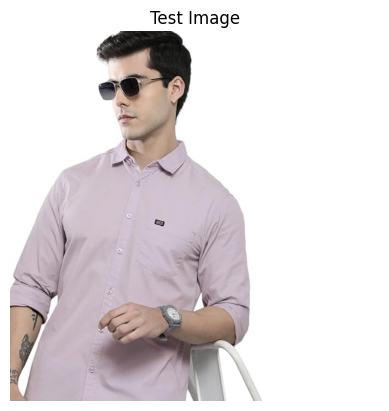

In [33]:
test_image_path = '/content/shirtss.jpg'


predicted_attributes = predict_image_attributes(model, test_image_path, label_encoders)

print(f"Predicted attributes for the image '{test_image_path}':")
print(f"Base Colour: {predicted_attributes['baseColour']}")
print(f"Article Type: {predicted_attributes['articleType']}")
print(f"Season: {predicted_attributes['season']}")
print(f"Gender: {predicted_attributes['gender']}")

# Display the image
img = Image.open(test_image_path)
plt.imshow(img)
plt.title("Test Image")
plt.axis('off')
plt.show()